In [1]:
import os, time, csv, random, math, glob
from pathlib import Path
from typing import Tuple, Optional
import shutil

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils

from IPython.display import clear_output
import matplotlib.pyplot as plt

from cleanfid import fid as cleanfid
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure as TM_MS_SSIM

In [2]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device:", device)

def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 연산에 대한 시드 설정
    torch.cuda.manual_seed(seed)  # CUDA 연산에 대한 시드 설정 (GPU 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용하는 경우 모든 GPU에 동일한 시드 설정
    np.random.seed(seed)  # NumPy 연산에 대한 시드 설정
    random.seed(seed)  # Python 기본 random 모듈의 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN 연산의 결정론적 동작 보장
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화 (재현성 보장)

set_random_seed(SEED)

Device: mps


In [13]:
DATA_DIR = Path.home() / "Desktop" / "Pokemonn"/"data"/"Dataset" 
PROJECT_ROOT = Path.home() / "Desktop" / "Pokemonn"
OUT_DIR    = DATA_DIR / "outputs"
SAMPLE_DIR = OUT_DIR / "samples"
CKPT_DIR   = OUT_DIR / "checkpoints"
FID_DIR    = OUT_DIR / "fid_samples"
PLOT_DIR   = OUT_DIR / "plots"
LOSS_CSV    = OUT_DIR / "loss_log.csv"      # 매 epoch
METRIC_CSV  = OUT_DIR / "metrics_log.csv"   # EVAL_EVERY마다
for p in [OUT_DIR, SAMPLE_DIR, CKPT_DIR, FID_DIR, PLOT_DIR]: p.mkdir(parents=True, exist_ok=True)

# Config

In [14]:
IMG_SIZE   = 128
CHANNELS   = 3
BATCH_SIZE = 64          # M4 Pro 권장 시작값(메모리 여유 시 48~64까지 올려보기)
NZ         = 128         # latent size
NGF        = 64
NDF        = 64
EPOCHS     = 1000
LR_G       = 2e-4
LR_D       = 1e-4          # TTUR: D 느리게
BETA1, BETA2 = 0.5, 0.999

LOG_EVERY  = 200           # step 출력 주기
SAVE_EVERY = 10           # epoch마다 샘플/체크포인트 저장
EVAL_EVERY = 20

REAL_LABEL = 0.9         # 라벨 스무딩
FAKE_LABEL = 0.0

FID_NUM_SAMP   = 256    # FID 샘플 수 (300~1000 권장)
MS_SSIM_MAX_N  = 64    # MS-SSIM 계산에 사용할 생성 샘플 수(성능/시간 균형)

# FID 설정

In [5]:
CUSTOM_FID_NAME = "pokemon128"
CUSTOM_FID_MODE = "clean"

# clean-fid의 기본 커스텀 통계 저장 위치: ~/.cache/clean-fid/custom_stats
CLEANFID_CUSTOM_DIR = Path.home() / ".cache" / "clean-fid" / "custom_stats"
CUSTOM_STATS_FILE = CLEANFID_CUSTOM_DIR / f"{CUSTOM_FID_NAME}_{CUSTOM_FID_MODE}.npz"

FORCE_REBUILD = False  # True로 바꾸면 기존 통계를 지우고 다시 만듭니다.

if FORCE_REBUILD and CUSTOM_STATS_FILE.exists():
    print(f"[CustomStats] removing existing stats → {CUSTOM_STATS_FILE}")
    # mode 인자를 지원하는 버전이면 mode=CUSTOM_FID_MODE를 같이 넘기세요.
    try:
        cleanfid.remove_custom_stats(CUSTOM_FID_NAME, mode=CUSTOM_FID_MODE)
    except TypeError:
        # 구버전 호환 (mode 인자 미지원)
        cleanfid.remove_custom_stats(CUSTOM_FID_NAME)

if not CUSTOM_STATS_FILE.exists():
    print(f"[CustomStats] not found → building stats for {DATA_DIR} ...")
    try:
        cleanfid.make_custom_stats(
            name=CUSTOM_FID_NAME,
            fdir=str(DATA_DIR),
            mode=CUSTOM_FID_MODE,     # 'clean'
            num_workers=0,            # macOS/MPS는 0이 안전
            batch_size=32,
            device=torch.device("cpu")
        )
        print(f"[CustomStats] saved → {CUSTOM_STATS_FILE}")
    except Exception as e:
        # 이미 존재 예외가 뜨면 조용히 통과 (경로 불일치로 재현될 수 있음)
        if "already exists" in str(e):
            print(f"[CustomStats] already exists → using {CUSTOM_STATS_FILE}")
        else:
            raise
else:
    print(f"[CustomStats] exists → {CUSTOM_STATS_FILE}")

[CustomStats] not found → building stats for /Users/leedoa/Desktop/PokemonGAN ...
[CustomStats] already exists → using /Users/leedoa/.cache/clean-fid/custom_stats/pokemon128_clean.npz


# Dataset

In [15]:
class ImageFolderRecursive(Dataset):
    SUP = (".png",".jpg",".jpeg",".webp",".bmp")
    def __init__(self, root: Path, img_size=128, augment=True):
        paths = []
        for e in self.SUP: paths += glob.glob(str(root / "**" / f"*{e}"), recursive=True)
        self.paths = sorted(set(paths))
        if not self.paths:
            raise RuntimeError(f"No images under: {root}")

        self.tf = T.Compose([
            # 작은 스프라이트/로고 많으면 RandomResizedCrop으로 객체 비중 키우기 추천
            T.Resize((img_size, img_size),
                               interpolation=T.InterpolationMode.BICUBIC),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),                         # [0,1]
            T.Normalize([0.5]*3, [0.5]*3)         # [-1,1]
        ])

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        return self.tf(img)

dataset = ImageFolderRecursive(DATA_DIR, IMG_SIZE, augment=True)
loader  = DataLoader(dataset, 
                     batch_size=BATCH_SIZE,
                     shuffle=True,
                     num_workers=0,
                     pin_memory=(device.type=="cuda"),
                     drop_last=True)
print(f"Loaded images: {len(dataset)}")


Loaded images: 898


# Model

In [16]:
# 가중치 초기화 함수 
def weights_init(m):
    # nn. -> nn.Conv2d 로 수정했습니다.
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        w = getattr(m, "weight_orig", getattr(m, "weight", None))
        if w is not None:
            nn.init.normal_(w, 0.0, 0.02)
    if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        if m.weight is not None: nn.init.normal_(m.weight, 1.0, 0.02)
        if m.bias   is not None: nn.init.zeros_(m.bias)

# 손실 함수 및 레이블 (기존 코드와 동일)
criterion = nn.BCEWithLogitsLoss().to(device)
REAL_LABEL = 0.9
FAKE_LABEL = 0.0

# 이미지 크기 설정 (데이터 로딩 시 필요)
IMG_CHANNELS = 3
IMG_SIZE = 128
IMG_SHAPE = (IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
IMG_FLAT_DIM = IMG_CHANNELS * IMG_SIZE * IMG_SIZE # 1차원으로 펼쳤을 때의 크기

#====================== 올바른 Vanilla GAN 구조 ===========================

class Generator(nn.Module):
    def __init__(self, nz=128):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(nz, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, IMG_FLAT_DIM),
            nn.Tanh() # 이미지를 -1에서 1 사이 값으로 출력
        )

    def forward(self, z):
        # 1차원 벡터로 이미지를 생성
        img_flat = self.main(z)
        # 생성된 벡터를 [B, C, H, W] 이미지 형태로 변환
        return img_flat.view(img_flat.size(0), *IMG_SHAPE)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Linear(IMG_FLAT_DIM, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1) # 최종 결과는 Sigmoid 없이 로짓(logit)으로 출력
        )

    def forward(self, img):
        # 입력 이미지를 1차원 벡터로 펼침
        img_flat = img.view(img.size(0), -1)
        # 펼쳐진 벡터를 입력하여 진짜/가짜 판별
        validity = self.main(img_flat)
        # BCEWithLogitsLoss에 맞게 차원 축소 후 반환
        return validity.squeeze()

# Util

In [17]:
def show_samples(epoch, netG, fixed_noise):
    netG.eval()
    with torch.no_grad():
        fake = netG(fixed_noise).to("cpu")
    grid = vutils.make_grid(fake, nrow=8, normalize=True, value_range=(-1,1))

    # 이전 출력 지우고 최신 그리드 표시 (노트북에 깔끔하게 업데이트)
    clear_output(wait=True)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.title(f'Generated Samples (epoch {epoch})')
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()
    netG.train()

def save_samples(epoch):
    netG.eval()
    with torch.no_grad():
        fake = netG(fixed_noise).to("cpu")
    grid = vutils.make_grid(fake, nrow=8, normalize=True, value_range=(-1,1))
    out = SAMPLE_DIR / f"epoch-{epoch:04d}.png"
    vutils.save_image(grid, out)
    print(f"[Sample] {out}")
    netG.train()

def save_ckpt(epoch, netG, netD, optG, optD):
    torch.save({
        "epoch": epoch,
        "netG": netG.state_dict(),
        "netD": netD.state_dict(),
        "optG": optG.state_dict(),
        "optD": optD.state_dict(),
        "nz": NZ, "img_size": IMG_SIZE
    }, CKPT_DIR / f"ckpt-{epoch:04d}.pt")

def _init_csv(path: Path, header: list):
    if not path.exists():
        with open(path, "w", newline="") as f:
            csv.writer(f).writerow(header)

def write_loss_row(epoch, g_avg, d_avg):
    _init_csv(LOSS_CSV, ["epoch","g_loss","d_loss"])
    with open(LOSS_CSV, "a", newline="") as f:
        csv.writer(f).writerow([epoch, f"{g_avg:.6f}", f"{d_avg:.6f}"])

def write_metric_row(epoch, fid_val, ms_val):
    _init_csv(METRIC_CSV, ["epoch","fid","ms_ssim"])
    with open(METRIC_CSV, "a", newline="") as f:
        csv.writer(f).writerow([
            epoch,
            "" if fid_val is None else f"{fid_val:.4f}",
            "" if ms_val  is None else f"{ms_val:.6f}"
        ])

# FID & MS-SSIM Calculation

In [23]:
# 👇 이 코드로 두 번째 코드 셀 전체를 교체해주세요.

MS_DEVICE = torch.device("cpu") if device.type == "mps" else device
MS_BETAS  = (0.0448, 0.2856, 0.3001, 0.2363, 0.1333)
MS_KERNEL = 7  

_ms_metric = TM_MS_SSIM(
    data_range=1.0,
    kernel_size=MS_KERNEL,
    betas=MS_BETAS
).to(MS_DEVICE)

def denorm(x: torch.Tensor) -> torch.Tensor:
    return (x.clamp(-1,1)+1)/2

@torch.no_grad()
def gen_for_fid(outdir: Path, num_images=FID_NUM_SAMP, batch=64):
    outdir.mkdir(parents=True, exist_ok=True)
    netG.eval()
    left = num_images
    while left > 0:
        cur = min(batch, left)
        
        # [수정된 부분] 바닐라 GAN에 맞게 2차원 벡터 노이즈를 생성합니다.
        z = torch.randn(cur, LATENT_DIM, device=device)
        
        fake = netG(z)
        for i in range(cur):
            vutils.save_image(denorm(fake[i].cpu()), str(outdir / f"{time.time_ns()}_{i}.png"))
        left -= cur
    netG.train()

def compute_fid_epoch(epoch: int) -> Tuple[float, Path]:
    gen_dir = FID_DIR / f"epoch_{epoch:04d}"
    gen_for_fid(gen_dir, num_images=FID_NUM_SAMP)
    fid_val = float(
        cleanfid.compute_fid(
            fdir1=str(gen_dir),
            dataset_name=CUSTOM_FID_NAME,
            dataset_split="custom",
            mode=CUSTOM_FID_MODE,
            num_workers=0,
            batch_size=32,
            device=torch.device("cpu"),
            use_dataparallel=False
        )
    )
    return fid_val, gen_dir

def compute_ms_ssim_intra(gen_dir: Path, max_imgs=MS_SSIM_MAX_N) -> Optional[float]:
    files = sorted([p for p in gen_dir.glob("*.png")])[:max_imgs]
    if len(files) < 2: return None
    tf = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])
    imgs = torch.stack([tf(Image.open(p).convert("RGB")) for p in files], 0).to(MS_DEVICE)
    perm = torch.randperm(imgs.size(0), device=imgs.device)
    a, b = imgs, imgs[perm]
    try:
        ms = _ms_metric(a, b).item()
    except Exception:
        a_cpu, b_cpu = a.cpu(), b.cpu()
        ms = TM_MS_SSIM(data_range=1.0)(a_cpu, b_cpu).item()
    return ms

# Loss

In [24]:
LOG_CSV = OUT_DIR / "logs.csv"
loss_hist = {"epoch": [], "g": [], "d": [], "fid": [], "ms_ssim": []}

def plot_and_save_curves():
    if len(loss_hist["epoch"]) == 0: return
    # 손실
    plt.figure(figsize=(7,4.2))
    plt.plot(loss_hist["epoch"], loss_hist["g"], label="G loss")
    plt.plot(loss_hist["epoch"], loss_hist["d"], label="D loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss (avg/epoch)")
    plt.legend(); plt.tight_layout()
    plt.savefig(PLOT_DIR / "loss_curves.png", dpi=140); plt.close()

    # FID (10 epoch 간격)
    xs_f, ys_f = [], []
    for e, f in zip(loss_hist["epoch"], loss_hist["fid"]):
        if f is not None: xs_f.append(e); ys_f.append(f)
    if xs_f:
        plt.figure(figsize=(7,4.2))
        plt.plot(xs_f, ys_f)
        plt.xlabel("Epoch"); plt.ylabel("FID (lower is better)")
        plt.title("FID every 10 epochs")
        plt.tight_layout()
        plt.savefig(PLOT_DIR / "fid_curve.png", dpi=140); plt.close()

    # MS-SSIM (10 epoch 간격) — 낮을수록 다양성↑
    xs_m, ys_m = [], []
    for e, m in zip(loss_hist["epoch"], loss_hist["ms_ssim"]):
        if m is not None: xs_m.append(e); ys_m.append(m)
    if xs_m:
        plt.figure(figsize=(7,4.2))
        plt.plot(xs_m, ys_m)
        plt.xlabel("Epoch"); plt.ylabel("MS-SSIM (lower = more diverse)")
        plt.title("MS-SSIM every 10 epochs")
        plt.tight_layout()
        plt.savefig(PLOT_DIR / "ms_ssim_curve.png", dpi=140); plt.close()

In [25]:
# 👇 이 코드를 복사해서 아무 셀에나 붙여넣고 실행해 보세요!
print("💡 스크립트가 생각하는 실제 저장 폴더는 바로 이곳입니다:")
print(SAMPLE_DIR.resolve())

💡 스크립트가 생각하는 실제 저장 폴더는 바로 이곳입니다:
/Users/leedoa/Desktop/Pokemonn/data/Dataset/outputs/samples


# Train

In [26]:
# =====================================================================
# 이 부분을 아래의 완성된 코드로 전체 교체해주세요.
# =====================================================================

# 바닐라 GAN에 맞는 하이퍼파라미터 정의
LATENT_DIM = 128  # 생성자가 입력받는 노이즈 벡터의 차원
NZ = LATENT_DIM   # 다른 코드와의 호환성을 위해 NZ도 동일하게 설정

netG = Generator(nz=LATENT_DIM) # 바닐라 GAN 생성자
netD = Discriminator()         # 바닐라 GAN 판별자

# 가중치 초기화
netG.apply(weights_init)
netD.apply(weights_init)

# Optimizer 설정
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))

# 훈련 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG.to(device)
netD.to(device)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 1000 # 요청하신 설정값 유지
EVAL_EVERY = 20

# [변경점] 바닐라 GAN은 1차원 벡터 노이즈를 사용합니다.
fixed_noise = torch.randn(64, LATENT_DIM, device=device)

print("🚀 Training starts for Vanilla GAN...")
# 훈련 루프=================================================
for epoch in range(num_epochs):
    g_loss_sum = 0.0
    d_loss_sum = 0.0
    
    for i, (data) in enumerate(loader, 0): # 라벨은 필요 없으므로 _로 받습니다.
        # --- 1. 판별자(Discriminator) 훈련 ---
        netD.zero_grad()
        real_images = data.to(device)
        b_size = real_images.size(0)
        
        # 실제 이미지에 대한 손실
        real_labels = torch.full((b_size,), 0.9, dtype=torch.float, device=device)
        output_real = netD(real_images) # .view(-1)는 모델 내부에서 처리
        errD_real = criterion(output_real, real_labels)
        errD_real.backward()

        # 가짜 이미지에 대한 손실
        # [변경점] 노이즈를 1차원 벡터 형태로 생성합니다.
        noise = torch.randn(b_size, LATENT_DIM, device=device)
        fake_images = netG(noise)
        fake_labels = torch.full((b_size,), 0.0, dtype=torch.float, device=device)
        output_fake = netD(fake_images.detach())
        errD_fake = criterion(output_fake, fake_labels)
        errD_fake.backward()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        # --- 2. 생성자(Generator) 훈련 ---
        netG.zero_grad()
        real_labels_for_G = torch.full((b_size,), 0.9, dtype=torch.float, device=device)
        output_g = netD(fake_images)
        errG = criterion(output_g, real_labels_for_G)
        errG.backward()
        optimizerG.step()
        
        g_loss_sum += errG.item()
        d_loss_sum += errD.item()

        if i % 100 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(loader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}")

    # --- 에포크 종료 후 처리 (이 부분은 기존과 동일) ---
    avg_g_loss = g_loss_sum / len(loader)
    avg_d_loss = d_loss_sum / len(loader)
    
    if (epoch + 1) % EVAL_EVERY == 0:
        print(f"\n--- Evaluating at Epoch {epoch+1} ---")
        with torch.no_grad():
            fake_samples = netG(fixed_noise).cpu()
        grid = vutils.make_grid(fake_samples, nrow=8, normalize=True, value_range=(-1,1))
        vutils.save_image(grid, SAMPLE_DIR / f"epoch_{(epoch+1):04d}.png")
        print(f"✅ Samples saved to: {SAMPLE_DIR / f'epoch_{(epoch+1):04d}.png'}")

        # FID 및 MS-SSIM 계산 (바닐라 GAN의 결과물은 품질이 낮아 점수가 높게 나올 수 있습니다)
        fid_val, gen_dir = compute_fid_epoch(epoch + 1)
        ms_val = compute_ms_ssim_intra(gen_dir)
        shutil.rmtree(gen_dir)
        print(f"[Metrics] FID: {fid_val:.2f} | MS-SSIM: {ms_val:.4f}")
        
        loss_hist["epoch"].append(epoch + 1)
        loss_hist["g"].append(avg_g_loss)
        loss_hist["d"].append(avg_d_loss)
        loss_hist["fid"].append(fid_val)
        loss_hist["ms_ssim"].append(ms_val)
    else:
        loss_hist["epoch"].append(epoch + 1)
        loss_hist["g"].append(avg_g_loss)
        loss_hist["d"].append(avg_d_loss)
        loss_hist["fid"].append(None)
        loss_hist["ms_ssim"].append(None)
        
    plot_and_save_curves()
    with open(LOSS_CSV, 'a', newline='') as f:
        writer = csv.writer(f)
        if (epoch + 1) == 1: writer.writerow(['epoch', 'g_loss', 'd_loss'])
        writer.writerow([epoch + 1, avg_g_loss, avg_d_loss])

    if (epoch + 1) % EVAL_EVERY == 0:
        with open(METRIC_CSV, 'a', newline='') as f:
            writer = csv.writer(f)
            if (epoch + 1) == EVAL_EVERY: writer.writerow(['epoch', 'fid', 'ms_ssim'])
            writer.writerow([epoch + 1, fid_val, ms_val])
            
    print(f"--- Epoch {epoch+1} finished. Avg Loss G: {avg_g_loss:.4f}, D: {avg_d_loss:.4f} ---\n")

print("🎉 Training Finished!")
with torch.no_grad():
    # [변경점] 최종 이미지 생성 시에도 1차원 벡터 노이즈 사용
    z = torch.randn(64, LATENT_DIM, device=device)
    fake = netG(z).cpu()
grid = vutils.make_grid(fake, nrow=8, normalize=True, value_range=(-1,1))
vutils.save_image(grid, SAMPLE_DIR / "final.png")
print(f"✅ Final image grid saved to {SAMPLE_DIR / 'final.png'}")

🚀 Training starts for Vanilla GAN...
[1/1000][0/14] Loss_D: 1.2876 Loss_G: 0.6847
--- Epoch 1 finished. Avg Loss G: 0.4573, D: 1.9590 ---

[2/1000][0/14] Loss_D: 2.4678 Loss_G: 0.4504
--- Epoch 2 finished. Avg Loss G: 0.7197, D: 1.6124 ---

[3/1000][0/14] Loss_D: 1.2786 Loss_G: 0.7185
--- Epoch 3 finished. Avg Loss G: 0.7188, D: 1.2354 ---

[4/1000][0/14] Loss_D: 1.1015 Loss_G: 0.7642
--- Epoch 4 finished. Avg Loss G: 0.7279, D: 1.1139 ---

[5/1000][0/14] Loss_D: 1.0250 Loss_G: 0.7663
--- Epoch 5 finished. Avg Loss G: 0.6910, D: 1.1122 ---

[6/1000][0/14] Loss_D: 1.2180 Loss_G: 0.6650
--- Epoch 6 finished. Avg Loss G: 0.7097, D: 1.1384 ---

[7/1000][0/14] Loss_D: 1.0895 Loss_G: 0.7165
--- Epoch 7 finished. Avg Loss G: 0.7279, D: 1.0530 ---

[8/1000][0/14] Loss_D: 1.0368 Loss_G: 0.7211
--- Epoch 8 finished. Avg Loss G: 0.7235, D: 1.0352 ---

[9/1000][0/14] Loss_D: 1.0086 Loss_G: 0.7297
--- Epoch 9 finished. Avg Loss G: 0.6870, D: 1.0756 ---

[10/1000][0/14] Loss_D: 1.1085 Loss_G: 0.7085

FID epoch_0020 : 100%|██████████| 8/8 [00:29<00:00,  3.66s/it]


[Metrics] FID: 521.54 | MS-SSIM: 0.9993
--- Epoch 20 finished. Avg Loss G: 0.7394, D: 1.0056 ---

[21/1000][0/14] Loss_D: 1.0121 Loss_G: 0.7315
--- Epoch 21 finished. Avg Loss G: 0.7276, D: 1.0143 ---

[22/1000][0/14] Loss_D: 1.0104 Loss_G: 0.7342
--- Epoch 22 finished. Avg Loss G: 0.7546, D: 0.9892 ---

[23/1000][0/14] Loss_D: 0.9886 Loss_G: 0.7478
--- Epoch 23 finished. Avg Loss G: 0.7542, D: 1.0005 ---

[24/1000][0/14] Loss_D: 0.9860 Loss_G: 0.7703
--- Epoch 24 finished. Avg Loss G: 0.7547, D: 1.0043 ---

[25/1000][0/14] Loss_D: 1.0092 Loss_G: 0.7567
--- Epoch 25 finished. Avg Loss G: 0.7548, D: 1.0058 ---

[26/1000][0/14] Loss_D: 0.9991 Loss_G: 0.7446
--- Epoch 26 finished. Avg Loss G: 0.7371, D: 1.0410 ---

[27/1000][0/14] Loss_D: 0.9490 Loss_G: 0.8232
--- Epoch 27 finished. Avg Loss G: 0.7492, D: 0.9977 ---

[28/1000][0/14] Loss_D: 1.1435 Loss_G: 0.6573
--- Epoch 28 finished. Avg Loss G: 0.7879, D: 1.0169 ---

[29/1000][0/14] Loss_D: 0.9611 Loss_G: 0.7715
--- Epoch 29 finished. A

FID epoch_0040 : 100%|██████████| 8/8 [00:29<00:00,  3.64s/it]


[Metrics] FID: 393.45 | MS-SSIM: 0.9993
--- Epoch 40 finished. Avg Loss G: 0.8008, D: 0.9737 ---

[41/1000][0/14] Loss_D: 0.9819 Loss_G: 0.7731
--- Epoch 41 finished. Avg Loss G: 0.7707, D: 0.9968 ---

[42/1000][0/14] Loss_D: 0.9777 Loss_G: 0.8124
--- Epoch 42 finished. Avg Loss G: 0.8034, D: 0.9687 ---

[43/1000][0/14] Loss_D: 0.9495 Loss_G: 0.8032
--- Epoch 43 finished. Avg Loss G: 0.7937, D: 0.9995 ---

[44/1000][0/14] Loss_D: 0.9717 Loss_G: 0.8697
--- Epoch 44 finished. Avg Loss G: 0.8260, D: 0.9589 ---

[45/1000][0/14] Loss_D: 0.9539 Loss_G: 0.8007
--- Epoch 45 finished. Avg Loss G: 0.8048, D: 0.9835 ---

[46/1000][0/14] Loss_D: 0.9263 Loss_G: 0.9023
--- Epoch 46 finished. Avg Loss G: 0.8325, D: 0.9797 ---

[47/1000][0/14] Loss_D: 0.9285 Loss_G: 0.8430
--- Epoch 47 finished. Avg Loss G: 0.8176, D: 0.9452 ---

[48/1000][0/14] Loss_D: 0.9535 Loss_G: 0.8194
--- Epoch 48 finished. Avg Loss G: 0.8207, D: 0.9684 ---

[49/1000][0/14] Loss_D: 0.9373 Loss_G: 0.8648
--- Epoch 49 finished. A

FID epoch_0060 : 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]


[Metrics] FID: 436.80 | MS-SSIM: 0.9990
--- Epoch 60 finished. Avg Loss G: 0.9207, D: 0.9212 ---

[61/1000][0/14] Loss_D: 0.8571 Loss_G: 0.9220
--- Epoch 61 finished. Avg Loss G: 0.8946, D: 0.8752 ---

[62/1000][0/14] Loss_D: 0.8875 Loss_G: 0.8663
--- Epoch 62 finished. Avg Loss G: 0.8933, D: 0.9193 ---

[63/1000][0/14] Loss_D: 0.8910 Loss_G: 0.9466
--- Epoch 63 finished. Avg Loss G: 0.9527, D: 0.8916 ---

[64/1000][0/14] Loss_D: 0.8512 Loss_G: 0.9442
--- Epoch 64 finished. Avg Loss G: 0.9214, D: 0.8618 ---

[65/1000][0/14] Loss_D: 0.8368 Loss_G: 0.9787
--- Epoch 65 finished. Avg Loss G: 0.9319, D: 0.8832 ---

[66/1000][0/14] Loss_D: 0.9215 Loss_G: 0.8980
--- Epoch 66 finished. Avg Loss G: 0.9793, D: 0.8685 ---

[67/1000][0/14] Loss_D: 0.8112 Loss_G: 0.9612
--- Epoch 67 finished. Avg Loss G: 0.9315, D: 0.8538 ---

[68/1000][0/14] Loss_D: 0.8875 Loss_G: 0.9319
--- Epoch 68 finished. Avg Loss G: 0.9634, D: 0.9049 ---

[69/1000][0/14] Loss_D: 0.8372 Loss_G: 0.9828
--- Epoch 69 finished. A

FID epoch_0080 : 100%|██████████| 8/8 [00:29<00:00,  3.68s/it]


[Metrics] FID: 438.16 | MS-SSIM: 0.9989
--- Epoch 80 finished. Avg Loss G: 1.0473, D: 0.7885 ---

[81/1000][0/14] Loss_D: 0.7871 Loss_G: 1.0441
--- Epoch 81 finished. Avg Loss G: 1.0554, D: 0.8301 ---

[82/1000][0/14] Loss_D: 0.8473 Loss_G: 1.0431
--- Epoch 82 finished. Avg Loss G: 1.0879, D: 0.8308 ---

[83/1000][0/14] Loss_D: 0.8171 Loss_G: 1.0752
--- Epoch 83 finished. Avg Loss G: 1.0532, D: 0.8992 ---

[84/1000][0/14] Loss_D: 0.8596 Loss_G: 1.0777
--- Epoch 84 finished. Avg Loss G: 1.1079, D: 0.8015 ---

[85/1000][0/14] Loss_D: 0.7803 Loss_G: 1.1536
--- Epoch 85 finished. Avg Loss G: 1.0972, D: 0.7871 ---

[86/1000][0/14] Loss_D: 0.8050 Loss_G: 1.0315
--- Epoch 86 finished. Avg Loss G: 1.1222, D: 0.7998 ---

[87/1000][0/14] Loss_D: 0.7817 Loss_G: 1.1168
--- Epoch 87 finished. Avg Loss G: 1.1192, D: 0.7630 ---

[88/1000][0/14] Loss_D: 0.7366 Loss_G: 1.1144
--- Epoch 88 finished. Avg Loss G: 1.1350, D: 0.7503 ---

[89/1000][0/14] Loss_D: 0.7248 Loss_G: 1.2088
--- Epoch 89 finished. A

FID epoch_0100 : 100%|██████████| 8/8 [00:29<00:00,  3.71s/it]


[Metrics] FID: 449.50 | MS-SSIM: 0.9949
--- Epoch 100 finished. Avg Loss G: 1.2964, D: 0.7174 ---

[101/1000][0/14] Loss_D: 0.7567 Loss_G: 1.1938
--- Epoch 101 finished. Avg Loss G: 1.1989, D: 0.7604 ---

[102/1000][0/14] Loss_D: 0.7381 Loss_G: 1.2615
--- Epoch 102 finished. Avg Loss G: 1.2462, D: 0.7296 ---

[103/1000][0/14] Loss_D: 0.6829 Loss_G: 1.2800
--- Epoch 103 finished. Avg Loss G: 1.2284, D: 0.7258 ---

[104/1000][0/14] Loss_D: 0.7612 Loss_G: 1.1309
--- Epoch 104 finished. Avg Loss G: 1.3004, D: 0.7303 ---

[105/1000][0/14] Loss_D: 0.7056 Loss_G: 1.2847
--- Epoch 105 finished. Avg Loss G: 1.3366, D: 0.7272 ---

[106/1000][0/14] Loss_D: 0.8806 Loss_G: 1.3649
--- Epoch 106 finished. Avg Loss G: 1.3406, D: 0.7200 ---

[107/1000][0/14] Loss_D: 0.6956 Loss_G: 1.3038
--- Epoch 107 finished. Avg Loss G: 1.3884, D: 0.6840 ---

[108/1000][0/14] Loss_D: 0.7055 Loss_G: 1.3390
--- Epoch 108 finished. Avg Loss G: 1.3525, D: 0.7242 ---

[109/1000][0/14] Loss_D: 0.7054 Loss_G: 1.6549
--- Ep

FID epoch_0120 : 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]


[Metrics] FID: 392.59 | MS-SSIM: 0.9838
--- Epoch 120 finished. Avg Loss G: 1.4909, D: 0.6669 ---

[121/1000][0/14] Loss_D: 0.7179 Loss_G: 1.4801
--- Epoch 121 finished. Avg Loss G: 1.5458, D: 0.6833 ---

[122/1000][0/14] Loss_D: 0.6026 Loss_G: 1.6068
--- Epoch 122 finished. Avg Loss G: 1.4917, D: 0.6589 ---

[123/1000][0/14] Loss_D: 0.6197 Loss_G: 1.5284
--- Epoch 123 finished. Avg Loss G: 1.5614, D: 0.6574 ---

[124/1000][0/14] Loss_D: 0.5995 Loss_G: 1.5997
--- Epoch 124 finished. Avg Loss G: 1.5518, D: 0.5972 ---

[125/1000][0/14] Loss_D: 0.5593 Loss_G: 1.6077
--- Epoch 125 finished. Avg Loss G: 1.4779, D: 0.6312 ---

[126/1000][0/14] Loss_D: 0.7145 Loss_G: 1.4250
--- Epoch 126 finished. Avg Loss G: 1.6253, D: 0.6784 ---

[127/1000][0/14] Loss_D: 0.5964 Loss_G: 1.6260
--- Epoch 127 finished. Avg Loss G: 1.5812, D: 0.6164 ---

[128/1000][0/14] Loss_D: 0.6418 Loss_G: 1.5704
--- Epoch 128 finished. Avg Loss G: 1.5439, D: 0.6755 ---

[129/1000][0/14] Loss_D: 0.7795 Loss_G: 2.1317
--- Ep

FID epoch_0140 : 100%|██████████| 8/8 [00:29<00:00,  3.68s/it]


[Metrics] FID: 419.84 | MS-SSIM: 0.9872
--- Epoch 140 finished. Avg Loss G: 1.6475, D: 0.5856 ---

[141/1000][0/14] Loss_D: 0.5762 Loss_G: 1.5766
--- Epoch 141 finished. Avg Loss G: 1.7685, D: 0.5960 ---

[142/1000][0/14] Loss_D: 0.5696 Loss_G: 1.8732
--- Epoch 142 finished. Avg Loss G: 1.7128, D: 0.6198 ---

[143/1000][0/14] Loss_D: 0.6483 Loss_G: 1.6943
--- Epoch 143 finished. Avg Loss G: 1.7645, D: 0.6909 ---

[144/1000][0/14] Loss_D: 0.5717 Loss_G: 1.8325
--- Epoch 144 finished. Avg Loss G: 1.7920, D: 0.5938 ---

[145/1000][0/14] Loss_D: 0.6056 Loss_G: 1.6236
--- Epoch 145 finished. Avg Loss G: 1.6532, D: 0.6119 ---

[146/1000][0/14] Loss_D: 0.7249 Loss_G: 1.7452
--- Epoch 146 finished. Avg Loss G: 1.5368, D: 0.8045 ---

[147/1000][0/14] Loss_D: 0.7407 Loss_G: 1.4199
--- Epoch 147 finished. Avg Loss G: 1.6183, D: 0.7346 ---

[148/1000][0/14] Loss_D: 0.6120 Loss_G: 1.8061
--- Epoch 148 finished. Avg Loss G: 1.6984, D: 0.6681 ---

[149/1000][0/14] Loss_D: 0.6265 Loss_G: 1.5217
--- Ep

FID epoch_0160 : 100%|██████████| 8/8 [00:29<00:00,  3.70s/it]


[Metrics] FID: 385.10 | MS-SSIM: 0.6550
--- Epoch 160 finished. Avg Loss G: 1.8083, D: 0.8904 ---

[161/1000][0/14] Loss_D: 0.8724 Loss_G: 1.4085
--- Epoch 161 finished. Avg Loss G: 1.7067, D: 0.8867 ---

[162/1000][0/14] Loss_D: 0.8295 Loss_G: 1.7541
--- Epoch 162 finished. Avg Loss G: 1.8298, D: 0.8074 ---

[163/1000][0/14] Loss_D: 0.7336 Loss_G: 1.9090
--- Epoch 163 finished. Avg Loss G: 1.7688, D: 0.7810 ---

[164/1000][0/14] Loss_D: 0.8119 Loss_G: 1.5750
--- Epoch 164 finished. Avg Loss G: 1.8067, D: 0.7851 ---

[165/1000][0/14] Loss_D: 0.9951 Loss_G: 1.5216
--- Epoch 165 finished. Avg Loss G: 1.7752, D: 0.8607 ---

[166/1000][0/14] Loss_D: 0.7101 Loss_G: 1.9610
--- Epoch 166 finished. Avg Loss G: 1.8344, D: 0.8339 ---

[167/1000][0/14] Loss_D: 0.7811 Loss_G: 2.1507
--- Epoch 167 finished. Avg Loss G: 1.7618, D: 0.8167 ---

[168/1000][0/14] Loss_D: 0.7523 Loss_G: 1.7790
--- Epoch 168 finished. Avg Loss G: 1.8204, D: 0.8374 ---

[169/1000][0/14] Loss_D: 0.7599 Loss_G: 2.0118
--- Ep

FID epoch_0180 : 100%|██████████| 8/8 [00:30<00:00,  3.78s/it]


[Metrics] FID: 354.54 | MS-SSIM: 0.5339
--- Epoch 180 finished. Avg Loss G: 1.7720, D: 0.9143 ---

[181/1000][0/14] Loss_D: 0.8742 Loss_G: 1.6760
--- Epoch 181 finished. Avg Loss G: 1.8202, D: 0.8970 ---

[182/1000][0/14] Loss_D: 0.8919 Loss_G: 1.8013
--- Epoch 182 finished. Avg Loss G: 1.8099, D: 0.9186 ---

[183/1000][0/14] Loss_D: 0.9097 Loss_G: 2.0468
--- Epoch 183 finished. Avg Loss G: 1.8041, D: 0.9016 ---

[184/1000][0/14] Loss_D: 0.8979 Loss_G: 2.2428
--- Epoch 184 finished. Avg Loss G: 1.9861, D: 1.0517 ---

[185/1000][0/14] Loss_D: 0.8719 Loss_G: 1.9307
--- Epoch 185 finished. Avg Loss G: 1.8722, D: 0.9763 ---

[186/1000][0/14] Loss_D: 0.8907 Loss_G: 1.9038
--- Epoch 186 finished. Avg Loss G: 1.8586, D: 0.9409 ---

[187/1000][0/14] Loss_D: 0.9224 Loss_G: 2.1214
--- Epoch 187 finished. Avg Loss G: 1.8787, D: 0.9192 ---

[188/1000][0/14] Loss_D: 0.9586 Loss_G: 1.3932
--- Epoch 188 finished. Avg Loss G: 1.8860, D: 1.0004 ---

[189/1000][0/14] Loss_D: 1.0080 Loss_G: 2.4103
--- Ep

FID epoch_0200 : 100%|██████████| 8/8 [00:28<00:00,  3.59s/it]


[Metrics] FID: 355.53 | MS-SSIM: 0.5453
--- Epoch 200 finished. Avg Loss G: 1.9828, D: 0.9164 ---

[201/1000][0/14] Loss_D: 1.0103 Loss_G: 1.4926
--- Epoch 201 finished. Avg Loss G: 1.9338, D: 0.9430 ---

[202/1000][0/14] Loss_D: 0.8797 Loss_G: 1.8307
--- Epoch 202 finished. Avg Loss G: 1.9274, D: 0.8723 ---

[203/1000][0/14] Loss_D: 0.7515 Loss_G: 2.2956
--- Epoch 203 finished. Avg Loss G: 1.8493, D: 0.8514 ---

[204/1000][0/14] Loss_D: 1.0567 Loss_G: 2.5396
--- Epoch 204 finished. Avg Loss G: 1.9637, D: 0.9300 ---

[205/1000][0/14] Loss_D: 0.8793 Loss_G: 1.6163
--- Epoch 205 finished. Avg Loss G: 2.0632, D: 0.9197 ---

[206/1000][0/14] Loss_D: 0.9609 Loss_G: 1.4517
--- Epoch 206 finished. Avg Loss G: 1.9496, D: 0.9505 ---

[207/1000][0/14] Loss_D: 0.8855 Loss_G: 2.1084
--- Epoch 207 finished. Avg Loss G: 1.9853, D: 0.9747 ---

[208/1000][0/14] Loss_D: 0.8264 Loss_G: 2.0550
--- Epoch 208 finished. Avg Loss G: 1.8955, D: 0.8974 ---

[209/1000][0/14] Loss_D: 0.7857 Loss_G: 1.8989
--- Ep

FID epoch_0220 : 100%|██████████| 8/8 [00:29<00:00,  3.66s/it]


[Metrics] FID: 349.60 | MS-SSIM: 0.4070
--- Epoch 220 finished. Avg Loss G: 1.7413, D: 1.0098 ---

[221/1000][0/14] Loss_D: 0.7887 Loss_G: 2.1193
--- Epoch 221 finished. Avg Loss G: 1.7956, D: 0.9114 ---

[222/1000][0/14] Loss_D: 0.8938 Loss_G: 1.8326
--- Epoch 222 finished. Avg Loss G: 1.8738, D: 0.9794 ---

[223/1000][0/14] Loss_D: 0.8791 Loss_G: 1.8877
--- Epoch 223 finished. Avg Loss G: 1.8718, D: 0.9574 ---

[224/1000][0/14] Loss_D: 0.9962 Loss_G: 1.6053
--- Epoch 224 finished. Avg Loss G: 1.9061, D: 0.9775 ---

[225/1000][0/14] Loss_D: 0.9056 Loss_G: 2.2912
--- Epoch 225 finished. Avg Loss G: 1.9320, D: 1.0179 ---

[226/1000][0/14] Loss_D: 1.0452 Loss_G: 2.2070
--- Epoch 226 finished. Avg Loss G: 1.8259, D: 0.9967 ---

[227/1000][0/14] Loss_D: 1.0286 Loss_G: 1.8649
--- Epoch 227 finished. Avg Loss G: 1.7481, D: 0.9612 ---

[228/1000][0/14] Loss_D: 0.9193 Loss_G: 2.0246
--- Epoch 228 finished. Avg Loss G: 1.8017, D: 0.9969 ---

[229/1000][0/14] Loss_D: 0.9757 Loss_G: 2.0481
--- Ep

FID epoch_0240 : 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]


[Metrics] FID: 348.38 | MS-SSIM: 0.3262
--- Epoch 240 finished. Avg Loss G: 1.8039, D: 0.9916 ---

[241/1000][0/14] Loss_D: 0.9041 Loss_G: 1.6563
--- Epoch 241 finished. Avg Loss G: 1.7878, D: 1.0167 ---

[242/1000][0/14] Loss_D: 1.0325 Loss_G: 1.6373
--- Epoch 242 finished. Avg Loss G: 1.7583, D: 1.0005 ---

[243/1000][0/14] Loss_D: 1.0460 Loss_G: 1.6614
--- Epoch 243 finished. Avg Loss G: 1.8285, D: 1.0470 ---

[244/1000][0/14] Loss_D: 1.0913 Loss_G: 2.3318
--- Epoch 244 finished. Avg Loss G: 1.8024, D: 1.0505 ---

[245/1000][0/14] Loss_D: 1.0166 Loss_G: 1.8022
--- Epoch 245 finished. Avg Loss G: 1.7733, D: 0.9951 ---

[246/1000][0/14] Loss_D: 0.9761 Loss_G: 1.8315
--- Epoch 246 finished. Avg Loss G: 1.7517, D: 1.0021 ---

[247/1000][0/14] Loss_D: 0.9213 Loss_G: 1.7380
--- Epoch 247 finished. Avg Loss G: 1.7828, D: 1.0319 ---

[248/1000][0/14] Loss_D: 0.9296 Loss_G: 1.9667
--- Epoch 248 finished. Avg Loss G: 1.7978, D: 1.0896 ---

[249/1000][0/14] Loss_D: 1.0886 Loss_G: 1.7247
--- Ep

FID epoch_0260 : 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]


[Metrics] FID: 340.33 | MS-SSIM: 0.2613
--- Epoch 260 finished. Avg Loss G: 1.6417, D: 1.0235 ---

[261/1000][0/14] Loss_D: 1.4161 Loss_G: 2.7768
--- Epoch 261 finished. Avg Loss G: 1.8089, D: 1.0659 ---

[262/1000][0/14] Loss_D: 1.0660 Loss_G: 1.7645
--- Epoch 262 finished. Avg Loss G: 1.6716, D: 1.0522 ---

[263/1000][0/14] Loss_D: 1.0507 Loss_G: 1.6984
--- Epoch 263 finished. Avg Loss G: 1.7684, D: 1.1070 ---

[264/1000][0/14] Loss_D: 0.9308 Loss_G: 1.9290
--- Epoch 264 finished. Avg Loss G: 1.8100, D: 1.0342 ---

[265/1000][0/14] Loss_D: 1.0805 Loss_G: 1.4845
--- Epoch 265 finished. Avg Loss G: 1.8319, D: 1.1036 ---

[266/1000][0/14] Loss_D: 1.0518 Loss_G: 1.8449
--- Epoch 266 finished. Avg Loss G: 1.8525, D: 1.0036 ---

[267/1000][0/14] Loss_D: 0.9108 Loss_G: 2.0820
--- Epoch 267 finished. Avg Loss G: 1.7594, D: 1.0397 ---

[268/1000][0/14] Loss_D: 1.0886 Loss_G: 1.3570
--- Epoch 268 finished. Avg Loss G: 1.8090, D: 1.0635 ---

[269/1000][0/14] Loss_D: 1.0422 Loss_G: 1.6865
--- Ep

FID epoch_0280 : 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]


[Metrics] FID: 337.22 | MS-SSIM: 0.3074
--- Epoch 280 finished. Avg Loss G: 1.8269, D: 1.1329 ---

[281/1000][0/14] Loss_D: 1.0189 Loss_G: 2.1370
--- Epoch 281 finished. Avg Loss G: 1.8381, D: 1.0776 ---

[282/1000][0/14] Loss_D: 1.1448 Loss_G: 1.4683
--- Epoch 282 finished. Avg Loss G: 1.7610, D: 1.0704 ---

[283/1000][0/14] Loss_D: 1.0388 Loss_G: 1.6291
--- Epoch 283 finished. Avg Loss G: 1.7306, D: 1.0423 ---

[284/1000][0/14] Loss_D: 0.9843 Loss_G: 1.8336
--- Epoch 284 finished. Avg Loss G: 1.7501, D: 1.0730 ---

[285/1000][0/14] Loss_D: 1.0930 Loss_G: 1.4093
--- Epoch 285 finished. Avg Loss G: 1.6282, D: 1.0965 ---

[286/1000][0/14] Loss_D: 1.1134 Loss_G: 1.6564
--- Epoch 286 finished. Avg Loss G: 1.6833, D: 1.0863 ---

[287/1000][0/14] Loss_D: 0.9910 Loss_G: 1.7866
--- Epoch 287 finished. Avg Loss G: 1.6509, D: 1.1018 ---

[288/1000][0/14] Loss_D: 1.0671 Loss_G: 1.8000
--- Epoch 288 finished. Avg Loss G: 1.7054, D: 1.0882 ---

[289/1000][0/14] Loss_D: 1.0927 Loss_G: 1.6979
--- Ep

FID epoch_0300 : 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]


[Metrics] FID: 336.47 | MS-SSIM: 0.3145
--- Epoch 300 finished. Avg Loss G: 1.7080, D: 1.0598 ---

[301/1000][0/14] Loss_D: 1.1400 Loss_G: 1.7652
--- Epoch 301 finished. Avg Loss G: 1.6548, D: 1.0632 ---

[302/1000][0/14] Loss_D: 1.0822 Loss_G: 1.5754
--- Epoch 302 finished. Avg Loss G: 1.6531, D: 1.0790 ---

[303/1000][0/14] Loss_D: 1.0834 Loss_G: 1.9170
--- Epoch 303 finished. Avg Loss G: 1.7195, D: 1.0588 ---

[304/1000][0/14] Loss_D: 1.0416 Loss_G: 1.6725
--- Epoch 304 finished. Avg Loss G: 1.7699, D: 1.0940 ---

[305/1000][0/14] Loss_D: 1.1664 Loss_G: 1.5504
--- Epoch 305 finished. Avg Loss G: 1.7790, D: 1.0873 ---

[306/1000][0/14] Loss_D: 1.0589 Loss_G: 1.4688
--- Epoch 306 finished. Avg Loss G: 1.6343, D: 1.1005 ---

[307/1000][0/14] Loss_D: 1.0771 Loss_G: 1.6455
--- Epoch 307 finished. Avg Loss G: 1.7034, D: 1.0565 ---

[308/1000][0/14] Loss_D: 1.1034 Loss_G: 2.2987
--- Epoch 308 finished. Avg Loss G: 1.7874, D: 1.0744 ---

[309/1000][0/14] Loss_D: 1.0787 Loss_G: 1.5805
--- Ep

FID epoch_0320 : 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]


[Metrics] FID: 335.72 | MS-SSIM: 0.2905
--- Epoch 320 finished. Avg Loss G: 1.6715, D: 1.0253 ---

[321/1000][0/14] Loss_D: 0.9530 Loss_G: 1.7530
--- Epoch 321 finished. Avg Loss G: 1.7499, D: 1.0519 ---

[322/1000][0/14] Loss_D: 0.9477 Loss_G: 2.0731
--- Epoch 322 finished. Avg Loss G: 1.7790, D: 1.0085 ---

[323/1000][0/14] Loss_D: 0.9685 Loss_G: 2.0754
--- Epoch 323 finished. Avg Loss G: 1.7291, D: 1.0026 ---

[324/1000][0/14] Loss_D: 0.9557 Loss_G: 1.9113
--- Epoch 324 finished. Avg Loss G: 1.7800, D: 1.0316 ---

[325/1000][0/14] Loss_D: 0.9547 Loss_G: 1.6325
--- Epoch 325 finished. Avg Loss G: 1.7371, D: 1.0816 ---

[326/1000][0/14] Loss_D: 0.9724 Loss_G: 2.1052
--- Epoch 326 finished. Avg Loss G: 1.7475, D: 1.0433 ---

[327/1000][0/14] Loss_D: 1.1164 Loss_G: 1.5138
--- Epoch 327 finished. Avg Loss G: 1.7339, D: 1.0505 ---

[328/1000][0/14] Loss_D: 0.8936 Loss_G: 2.0216
--- Epoch 328 finished. Avg Loss G: 1.7525, D: 1.0920 ---

[329/1000][0/14] Loss_D: 1.0922 Loss_G: 2.0937
--- Ep

FID epoch_0340 : 100%|██████████| 8/8 [00:39<00:00,  4.91s/it]


[Metrics] FID: 334.68 | MS-SSIM: 0.2391
--- Epoch 340 finished. Avg Loss G: 1.6680, D: 1.0519 ---

[341/1000][0/14] Loss_D: 0.9627 Loss_G: 2.0756
--- Epoch 341 finished. Avg Loss G: 1.7233, D: 1.0839 ---

[342/1000][0/14] Loss_D: 1.0450 Loss_G: 1.4089
--- Epoch 342 finished. Avg Loss G: 1.6874, D: 1.0880 ---

[343/1000][0/14] Loss_D: 0.9767 Loss_G: 1.6948
--- Epoch 343 finished. Avg Loss G: 1.7128, D: 1.0843 ---

[344/1000][0/14] Loss_D: 1.1099 Loss_G: 1.6185
--- Epoch 344 finished. Avg Loss G: 1.7665, D: 1.0809 ---

[345/1000][0/14] Loss_D: 0.9805 Loss_G: 1.8761
--- Epoch 345 finished. Avg Loss G: 1.7417, D: 1.1277 ---

[346/1000][0/14] Loss_D: 1.0471 Loss_G: 1.7845
--- Epoch 346 finished. Avg Loss G: 1.8117, D: 1.1227 ---

[347/1000][0/14] Loss_D: 1.0910 Loss_G: 1.4153
--- Epoch 347 finished. Avg Loss G: 1.6849, D: 1.0342 ---

[348/1000][0/14] Loss_D: 0.9798 Loss_G: 1.6616
--- Epoch 348 finished. Avg Loss G: 1.7079, D: 1.1231 ---

[349/1000][0/14] Loss_D: 1.0288 Loss_G: 1.8240
--- Ep

FID epoch_0360 : 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]


[Metrics] FID: 334.07 | MS-SSIM: 0.2892
--- Epoch 360 finished. Avg Loss G: 1.8315, D: 1.0659 ---

[361/1000][0/14] Loss_D: 0.9769 Loss_G: 1.7980
--- Epoch 361 finished. Avg Loss G: 1.7579, D: 1.0255 ---

[362/1000][0/14] Loss_D: 1.0050 Loss_G: 1.4624
--- Epoch 362 finished. Avg Loss G: 1.8174, D: 1.0466 ---

[363/1000][0/14] Loss_D: 0.9920 Loss_G: 1.8957
--- Epoch 363 finished. Avg Loss G: 1.8251, D: 1.0431 ---

[364/1000][0/14] Loss_D: 0.9792 Loss_G: 1.9385
--- Epoch 364 finished. Avg Loss G: 1.8007, D: 0.9970 ---

[365/1000][0/14] Loss_D: 0.9362 Loss_G: 1.8108
--- Epoch 365 finished. Avg Loss G: 1.7003, D: 1.0051 ---

[366/1000][0/14] Loss_D: 0.9233 Loss_G: 1.9075
--- Epoch 366 finished. Avg Loss G: 1.7786, D: 1.0538 ---

[367/1000][0/14] Loss_D: 1.0442 Loss_G: 1.9140
--- Epoch 367 finished. Avg Loss G: 1.7527, D: 1.0175 ---

[368/1000][0/14] Loss_D: 1.0334 Loss_G: 1.8939
--- Epoch 368 finished. Avg Loss G: 1.8300, D: 1.0683 ---

[369/1000][0/14] Loss_D: 1.0522 Loss_G: 1.9228
--- Ep

FID epoch_0380 : 100%|██████████| 8/8 [00:29<00:00,  3.69s/it]


[Metrics] FID: 336.32 | MS-SSIM: 0.2316
--- Epoch 380 finished. Avg Loss G: 1.6992, D: 1.0196 ---

[381/1000][0/14] Loss_D: 1.0044 Loss_G: 1.6243
--- Epoch 381 finished. Avg Loss G: 1.7121, D: 1.0428 ---

[382/1000][0/14] Loss_D: 1.0642 Loss_G: 1.9784
--- Epoch 382 finished. Avg Loss G: 1.8601, D: 0.9982 ---

[383/1000][0/14] Loss_D: 0.9610 Loss_G: 1.7885
--- Epoch 383 finished. Avg Loss G: 1.7925, D: 0.9576 ---

[384/1000][0/14] Loss_D: 0.9031 Loss_G: 1.7446
--- Epoch 384 finished. Avg Loss G: 1.7788, D: 0.9313 ---

[385/1000][0/14] Loss_D: 0.9692 Loss_G: 1.7073
--- Epoch 385 finished. Avg Loss G: 1.8207, D: 0.9729 ---

[386/1000][0/14] Loss_D: 0.9604 Loss_G: 1.7360
--- Epoch 386 finished. Avg Loss G: 1.7991, D: 0.9758 ---

[387/1000][0/14] Loss_D: 0.9522 Loss_G: 1.8476
--- Epoch 387 finished. Avg Loss G: 1.7825, D: 0.9649 ---

[388/1000][0/14] Loss_D: 0.9434 Loss_G: 1.9912
--- Epoch 388 finished. Avg Loss G: 1.7845, D: 0.9905 ---

[389/1000][0/14] Loss_D: 1.0213 Loss_G: 1.7140
--- Ep

FID epoch_0400 : 100%|██████████| 8/8 [00:29<00:00,  3.75s/it]


[Metrics] FID: 331.59 | MS-SSIM: 0.1858
--- Epoch 400 finished. Avg Loss G: 1.8715, D: 0.9805 ---

[401/1000][0/14] Loss_D: 1.0236 Loss_G: 1.6436
--- Epoch 401 finished. Avg Loss G: 1.8176, D: 0.9928 ---

[402/1000][0/14] Loss_D: 0.9705 Loss_G: 1.7375
--- Epoch 402 finished. Avg Loss G: 1.7764, D: 0.9923 ---

[403/1000][0/14] Loss_D: 0.9781 Loss_G: 1.8814
--- Epoch 403 finished. Avg Loss G: 1.9556, D: 1.0276 ---

[404/1000][0/14] Loss_D: 1.0129 Loss_G: 1.5243
--- Epoch 404 finished. Avg Loss G: 1.9186, D: 1.0057 ---

[405/1000][0/14] Loss_D: 0.8652 Loss_G: 2.0448
--- Epoch 405 finished. Avg Loss G: 1.8295, D: 0.9567 ---

[406/1000][0/14] Loss_D: 0.9279 Loss_G: 1.8752
--- Epoch 406 finished. Avg Loss G: 1.8963, D: 0.9981 ---

[407/1000][0/14] Loss_D: 0.9462 Loss_G: 1.8245
--- Epoch 407 finished. Avg Loss G: 1.8654, D: 0.9595 ---

[408/1000][0/14] Loss_D: 0.9099 Loss_G: 2.0329
--- Epoch 408 finished. Avg Loss G: 1.8114, D: 0.9298 ---

[409/1000][0/14] Loss_D: 0.9264 Loss_G: 1.6106
--- Ep

FID epoch_0420 : 100%|██████████| 8/8 [00:29<00:00,  3.71s/it]


[Metrics] FID: 329.12 | MS-SSIM: 0.2695
--- Epoch 420 finished. Avg Loss G: 1.8997, D: 0.9850 ---

[421/1000][0/14] Loss_D: 0.9524 Loss_G: 1.8589
--- Epoch 421 finished. Avg Loss G: 1.8866, D: 0.9343 ---

[422/1000][0/14] Loss_D: 0.8457 Loss_G: 2.1713
--- Epoch 422 finished. Avg Loss G: 1.9185, D: 0.9572 ---

[423/1000][0/14] Loss_D: 0.8732 Loss_G: 2.0165
--- Epoch 423 finished. Avg Loss G: 1.9304, D: 0.9221 ---

[424/1000][0/14] Loss_D: 0.8420 Loss_G: 2.3464
--- Epoch 424 finished. Avg Loss G: 1.9434, D: 0.9446 ---

[425/1000][0/14] Loss_D: 0.9225 Loss_G: 1.8832
--- Epoch 425 finished. Avg Loss G: 1.8533, D: 0.9219 ---

[426/1000][0/14] Loss_D: 0.9383 Loss_G: 2.0994
--- Epoch 426 finished. Avg Loss G: 1.9196, D: 0.9645 ---

[427/1000][0/14] Loss_D: 0.9230 Loss_G: 1.8862
--- Epoch 427 finished. Avg Loss G: 1.9268, D: 0.9333 ---

[428/1000][0/14] Loss_D: 0.8978 Loss_G: 2.3852
--- Epoch 428 finished. Avg Loss G: 2.0021, D: 0.9249 ---

[429/1000][0/14] Loss_D: 0.8681 Loss_G: 1.9640
--- Ep

FID epoch_0440 : 100%|██████████| 8/8 [00:29<00:00,  3.67s/it]


[Metrics] FID: 333.91 | MS-SSIM: 0.2440
--- Epoch 440 finished. Avg Loss G: 1.9306, D: 0.9119 ---

[441/1000][0/14] Loss_D: 0.9178 Loss_G: 2.0906
--- Epoch 441 finished. Avg Loss G: 1.9020, D: 0.9215 ---

[442/1000][0/14] Loss_D: 0.8998 Loss_G: 2.2204
--- Epoch 442 finished. Avg Loss G: 1.9920, D: 0.9096 ---

[443/1000][0/14] Loss_D: 0.8302 Loss_G: 1.8571
--- Epoch 443 finished. Avg Loss G: 1.9477, D: 0.9150 ---

[444/1000][0/14] Loss_D: 0.8623 Loss_G: 1.8202
--- Epoch 444 finished. Avg Loss G: 1.9677, D: 0.9027 ---

[445/1000][0/14] Loss_D: 0.8457 Loss_G: 1.8950
--- Epoch 445 finished. Avg Loss G: 1.9392, D: 0.8823 ---

[446/1000][0/14] Loss_D: 0.8128 Loss_G: 2.2623
--- Epoch 446 finished. Avg Loss G: 1.9513, D: 0.8422 ---

[447/1000][0/14] Loss_D: 0.8336 Loss_G: 1.9872
--- Epoch 447 finished. Avg Loss G: 1.9248, D: 0.8649 ---

[448/1000][0/14] Loss_D: 0.8078 Loss_G: 1.8739
--- Epoch 448 finished. Avg Loss G: 2.0275, D: 0.8866 ---

[449/1000][0/14] Loss_D: 0.8934 Loss_G: 1.8120
--- Ep

FID epoch_0460 : 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]


[Metrics] FID: 327.59 | MS-SSIM: 0.2747
--- Epoch 460 finished. Avg Loss G: 1.9899, D: 0.8848 ---

[461/1000][0/14] Loss_D: 0.8414 Loss_G: 2.0107
--- Epoch 461 finished. Avg Loss G: 1.9874, D: 0.9088 ---

[462/1000][0/14] Loss_D: 0.8706 Loss_G: 1.9685
--- Epoch 462 finished. Avg Loss G: 2.0372, D: 0.9129 ---

[463/1000][0/14] Loss_D: 0.9007 Loss_G: 1.9573
--- Epoch 463 finished. Avg Loss G: 2.0478, D: 0.9248 ---

[464/1000][0/14] Loss_D: 1.0172 Loss_G: 2.0936
--- Epoch 464 finished. Avg Loss G: 2.0299, D: 0.8820 ---

[465/1000][0/14] Loss_D: 0.8750 Loss_G: 1.9176
--- Epoch 465 finished. Avg Loss G: 1.9760, D: 0.8678 ---

[466/1000][0/14] Loss_D: 0.8878 Loss_G: 2.4148
--- Epoch 466 finished. Avg Loss G: 2.0041, D: 0.8767 ---

[467/1000][0/14] Loss_D: 0.9143 Loss_G: 2.2819
--- Epoch 467 finished. Avg Loss G: 2.0170, D: 0.8715 ---

[468/1000][0/14] Loss_D: 0.7649 Loss_G: 2.1274
--- Epoch 468 finished. Avg Loss G: 1.9387, D: 0.8767 ---

[469/1000][0/14] Loss_D: 0.7797 Loss_G: 2.0300
--- Ep

FID epoch_0480 : 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]


[Metrics] FID: 331.20 | MS-SSIM: 0.2095
--- Epoch 480 finished. Avg Loss G: 2.0633, D: 0.8336 ---

[481/1000][0/14] Loss_D: 0.8533 Loss_G: 1.9414
--- Epoch 481 finished. Avg Loss G: 2.0121, D: 0.8745 ---

[482/1000][0/14] Loss_D: 0.8314 Loss_G: 2.3180
--- Epoch 482 finished. Avg Loss G: 2.1326, D: 0.8786 ---

[483/1000][0/14] Loss_D: 0.8328 Loss_G: 2.2388
--- Epoch 483 finished. Avg Loss G: 2.1488, D: 0.8684 ---

[484/1000][0/14] Loss_D: 0.7720 Loss_G: 2.2316
--- Epoch 484 finished. Avg Loss G: 2.1075, D: 0.8631 ---

[485/1000][0/14] Loss_D: 0.8632 Loss_G: 2.2698
--- Epoch 485 finished. Avg Loss G: 2.1348, D: 0.8895 ---

[486/1000][0/14] Loss_D: 0.8896 Loss_G: 2.2039
--- Epoch 486 finished. Avg Loss G: 2.1301, D: 0.8457 ---

[487/1000][0/14] Loss_D: 0.9032 Loss_G: 1.7603
--- Epoch 487 finished. Avg Loss G: 2.0373, D: 0.8385 ---

[488/1000][0/14] Loss_D: 0.7738 Loss_G: 2.0342
--- Epoch 488 finished. Avg Loss G: 2.1108, D: 0.8521 ---

[489/1000][0/14] Loss_D: 1.0096 Loss_G: 2.7069
--- Ep

FID epoch_0500 : 100%|██████████| 8/8 [00:30<00:00,  3.78s/it]


[Metrics] FID: 330.62 | MS-SSIM: 0.2051
--- Epoch 500 finished. Avg Loss G: 2.1391, D: 0.7867 ---

[501/1000][0/14] Loss_D: 0.8939 Loss_G: 2.5624
--- Epoch 501 finished. Avg Loss G: 2.1175, D: 0.8558 ---

[502/1000][0/14] Loss_D: 0.8438 Loss_G: 2.3832
--- Epoch 502 finished. Avg Loss G: 2.1707, D: 0.8170 ---

[503/1000][0/14] Loss_D: 0.7517 Loss_G: 2.2501
--- Epoch 503 finished. Avg Loss G: 2.1277, D: 0.8213 ---

[504/1000][0/14] Loss_D: 0.7283 Loss_G: 2.2312
--- Epoch 504 finished. Avg Loss G: 2.1369, D: 0.8223 ---

[505/1000][0/14] Loss_D: 0.8581 Loss_G: 2.3169
--- Epoch 505 finished. Avg Loss G: 2.1492, D: 0.8409 ---

[506/1000][0/14] Loss_D: 0.7776 Loss_G: 1.9404
--- Epoch 506 finished. Avg Loss G: 2.1416, D: 0.7848 ---

[507/1000][0/14] Loss_D: 0.7790 Loss_G: 2.2959
--- Epoch 507 finished. Avg Loss G: 2.1702, D: 0.7965 ---

[508/1000][0/14] Loss_D: 0.7050 Loss_G: 2.1044
--- Epoch 508 finished. Avg Loss G: 2.1747, D: 0.7683 ---

[509/1000][0/14] Loss_D: 0.7363 Loss_G: 2.0276
--- Ep

FID epoch_0520 : 100%|██████████| 8/8 [00:35<00:00,  4.43s/it]


[Metrics] FID: 331.78 | MS-SSIM: 0.2037
--- Epoch 520 finished. Avg Loss G: 2.1412, D: 0.7794 ---

[521/1000][0/14] Loss_D: 0.7433 Loss_G: 1.9979
--- Epoch 521 finished. Avg Loss G: 2.1777, D: 0.7867 ---

[522/1000][0/14] Loss_D: 0.9400 Loss_G: 2.1504
--- Epoch 522 finished. Avg Loss G: 2.2192, D: 0.8132 ---

[523/1000][0/14] Loss_D: 0.6944 Loss_G: 2.2276
--- Epoch 523 finished. Avg Loss G: 2.2234, D: 0.8020 ---

[524/1000][0/14] Loss_D: 0.7221 Loss_G: 2.3323
--- Epoch 524 finished. Avg Loss G: 2.2480, D: 0.7709 ---

[525/1000][0/14] Loss_D: 0.7193 Loss_G: 2.3265
--- Epoch 525 finished. Avg Loss G: 2.2491, D: 0.7835 ---

[526/1000][0/14] Loss_D: 0.7621 Loss_G: 2.0125
--- Epoch 526 finished. Avg Loss G: 2.2305, D: 0.7882 ---

[527/1000][0/14] Loss_D: 0.7944 Loss_G: 2.8985
--- Epoch 527 finished. Avg Loss G: 2.2880, D: 0.7819 ---

[528/1000][0/14] Loss_D: 0.8269 Loss_G: 2.1060
--- Epoch 528 finished. Avg Loss G: 2.2188, D: 0.7788 ---

[529/1000][0/14] Loss_D: 0.7683 Loss_G: 1.8035
--- Ep

FID epoch_0540 : 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]


[Metrics] FID: 329.17 | MS-SSIM: 0.2023
--- Epoch 540 finished. Avg Loss G: 2.3519, D: 0.7212 ---

[541/1000][0/14] Loss_D: 0.6708 Loss_G: 2.5348
--- Epoch 541 finished. Avg Loss G: 2.2738, D: 0.7364 ---

[542/1000][0/14] Loss_D: 0.7235 Loss_G: 2.6218
--- Epoch 542 finished. Avg Loss G: 2.4286, D: 0.7399 ---

[543/1000][0/14] Loss_D: 0.6844 Loss_G: 2.3688
--- Epoch 543 finished. Avg Loss G: 2.2832, D: 0.7480 ---

[544/1000][0/14] Loss_D: 0.7571 Loss_G: 2.7978
--- Epoch 544 finished. Avg Loss G: 2.3612, D: 0.7426 ---

[545/1000][0/14] Loss_D: 0.7050 Loss_G: 2.5665
--- Epoch 545 finished. Avg Loss G: 2.3843, D: 0.7713 ---

[546/1000][0/14] Loss_D: 0.8175 Loss_G: 2.1122
--- Epoch 546 finished. Avg Loss G: 2.3372, D: 0.7496 ---

[547/1000][0/14] Loss_D: 0.6722 Loss_G: 2.6982
--- Epoch 547 finished. Avg Loss G: 2.3955, D: 0.7372 ---

[548/1000][0/14] Loss_D: 0.7764 Loss_G: 2.0930
--- Epoch 548 finished. Avg Loss G: 2.4148, D: 0.7142 ---

[549/1000][0/14] Loss_D: 0.6008 Loss_G: 2.6043
--- Ep

FID epoch_0560 : 100%|██████████| 8/8 [00:32<00:00,  4.06s/it]


[Metrics] FID: 331.42 | MS-SSIM: 0.2494
--- Epoch 560 finished. Avg Loss G: 2.4129, D: 0.7286 ---

[561/1000][0/14] Loss_D: 0.7472 Loss_G: 2.1687
--- Epoch 561 finished. Avg Loss G: 2.3999, D: 0.7087 ---

[562/1000][0/14] Loss_D: 0.6681 Loss_G: 2.3100
--- Epoch 562 finished. Avg Loss G: 2.4194, D: 0.7286 ---

[563/1000][0/14] Loss_D: 0.6987 Loss_G: 2.1210
--- Epoch 563 finished. Avg Loss G: 2.4086, D: 0.7199 ---

[564/1000][0/14] Loss_D: 0.7224 Loss_G: 2.1740
--- Epoch 564 finished. Avg Loss G: 2.3566, D: 0.7096 ---

[565/1000][0/14] Loss_D: 0.7953 Loss_G: 2.3118
--- Epoch 565 finished. Avg Loss G: 2.3573, D: 0.7191 ---

[566/1000][0/14] Loss_D: 0.6644 Loss_G: 2.9803
--- Epoch 566 finished. Avg Loss G: 2.3852, D: 0.7129 ---

[567/1000][0/14] Loss_D: 0.7040 Loss_G: 2.4843
--- Epoch 567 finished. Avg Loss G: 2.3930, D: 0.7061 ---

[568/1000][0/14] Loss_D: 0.6682 Loss_G: 2.8061
--- Epoch 568 finished. Avg Loss G: 2.4019, D: 0.7095 ---

[569/1000][0/14] Loss_D: 0.6521 Loss_G: 2.7608
--- Ep

FID epoch_0580 : 100%|██████████| 8/8 [00:34<00:00,  4.27s/it]


[Metrics] FID: 332.72 | MS-SSIM: 0.2468
--- Epoch 580 finished. Avg Loss G: 2.4547, D: 0.6951 ---

[581/1000][0/14] Loss_D: 0.6828 Loss_G: 2.7426
--- Epoch 581 finished. Avg Loss G: 2.4325, D: 0.6703 ---

[582/1000][0/14] Loss_D: 0.6205 Loss_G: 2.7525
--- Epoch 582 finished. Avg Loss G: 2.5305, D: 0.6772 ---

[583/1000][0/14] Loss_D: 0.7559 Loss_G: 2.6813
--- Epoch 583 finished. Avg Loss G: 2.5412, D: 0.7004 ---

[584/1000][0/14] Loss_D: 0.7215 Loss_G: 2.5658
--- Epoch 584 finished. Avg Loss G: 2.4833, D: 0.7212 ---

[585/1000][0/14] Loss_D: 0.6908 Loss_G: 2.4917
--- Epoch 585 finished. Avg Loss G: 2.4970, D: 0.7211 ---

[586/1000][0/14] Loss_D: 0.6512 Loss_G: 2.7360
--- Epoch 586 finished. Avg Loss G: 2.5005, D: 0.7534 ---

[587/1000][0/14] Loss_D: 0.7253 Loss_G: 2.4025
--- Epoch 587 finished. Avg Loss G: 2.4738, D: 0.7100 ---

[588/1000][0/14] Loss_D: 0.6015 Loss_G: 2.7749
--- Epoch 588 finished. Avg Loss G: 2.4658, D: 0.6983 ---

[589/1000][0/14] Loss_D: 0.6486 Loss_G: 2.3997
--- Ep

FID epoch_0600 : 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]


[Metrics] FID: 330.43 | MS-SSIM: 0.1712
--- Epoch 600 finished. Avg Loss G: 2.5602, D: 0.7228 ---

[601/1000][0/14] Loss_D: 0.6454 Loss_G: 2.6847
--- Epoch 601 finished. Avg Loss G: 2.6185, D: 0.7069 ---

[602/1000][0/14] Loss_D: 0.6611 Loss_G: 2.4078
--- Epoch 602 finished. Avg Loss G: 2.5725, D: 0.6638 ---

[603/1000][0/14] Loss_D: 0.6589 Loss_G: 2.2972
--- Epoch 603 finished. Avg Loss G: 2.6377, D: 0.6961 ---

[604/1000][0/14] Loss_D: 0.5997 Loss_G: 2.7456
--- Epoch 604 finished. Avg Loss G: 2.6037, D: 0.6578 ---

[605/1000][0/14] Loss_D: 0.5990 Loss_G: 2.9629
--- Epoch 605 finished. Avg Loss G: 2.5516, D: 0.6388 ---

[606/1000][0/14] Loss_D: 0.5764 Loss_G: 2.8510
--- Epoch 606 finished. Avg Loss G: 2.6180, D: 0.6720 ---

[607/1000][0/14] Loss_D: 0.6601 Loss_G: 2.6430
--- Epoch 607 finished. Avg Loss G: 2.5382, D: 0.6288 ---

[608/1000][0/14] Loss_D: 0.5587 Loss_G: 2.7862
--- Epoch 608 finished. Avg Loss G: 2.6810, D: 0.6533 ---

[609/1000][0/14] Loss_D: 0.6100 Loss_G: 2.5763
--- Ep

FID epoch_0620 : 100%|██████████| 8/8 [00:32<00:00,  4.09s/it]


[Metrics] FID: 332.99 | MS-SSIM: 0.1339
--- Epoch 620 finished. Avg Loss G: 2.6491, D: 0.6362 ---

[621/1000][0/14] Loss_D: 0.6589 Loss_G: 2.7625
--- Epoch 621 finished. Avg Loss G: 2.6007, D: 0.6156 ---

[622/1000][0/14] Loss_D: 0.5913 Loss_G: 3.0173
--- Epoch 622 finished. Avg Loss G: 2.6310, D: 0.6177 ---

[623/1000][0/14] Loss_D: 0.6617 Loss_G: 2.4464
--- Epoch 623 finished. Avg Loss G: 2.6589, D: 0.6313 ---

[624/1000][0/14] Loss_D: 0.6062 Loss_G: 2.7935
--- Epoch 624 finished. Avg Loss G: 2.6397, D: 0.6388 ---

[625/1000][0/14] Loss_D: 0.5798 Loss_G: 2.8526
--- Epoch 625 finished. Avg Loss G: 2.6384, D: 0.6136 ---

[626/1000][0/14] Loss_D: 0.5770 Loss_G: 2.5928
--- Epoch 626 finished. Avg Loss G: 2.6445, D: 0.5921 ---

[627/1000][0/14] Loss_D: 0.6044 Loss_G: 2.7358
--- Epoch 627 finished. Avg Loss G: 2.7172, D: 0.6150 ---

[628/1000][0/14] Loss_D: 0.6076 Loss_G: 2.7518
--- Epoch 628 finished. Avg Loss G: 2.7312, D: 0.6188 ---

[629/1000][0/14] Loss_D: 0.6274 Loss_G: 3.1607
--- Ep

FID epoch_0640 : 100%|██████████| 8/8 [00:36<00:00,  4.58s/it]


[Metrics] FID: 333.99 | MS-SSIM: 0.2180
--- Epoch 640 finished. Avg Loss G: 2.7234, D: 0.6577 ---

[641/1000][0/14] Loss_D: 0.6768 Loss_G: 3.1040
--- Epoch 641 finished. Avg Loss G: 2.7442, D: 0.6613 ---

[642/1000][0/14] Loss_D: 0.5805 Loss_G: 3.0670
--- Epoch 642 finished. Avg Loss G: 2.7826, D: 0.6280 ---

[643/1000][0/14] Loss_D: 0.5881 Loss_G: 3.0624
--- Epoch 643 finished. Avg Loss G: 2.8052, D: 0.6307 ---

[644/1000][0/14] Loss_D: 0.5501 Loss_G: 2.8933
--- Epoch 644 finished. Avg Loss G: 2.9051, D: 0.6137 ---

[645/1000][0/14] Loss_D: 0.6559 Loss_G: 3.1104
--- Epoch 645 finished. Avg Loss G: 3.0613, D: 0.6320 ---

[646/1000][0/14] Loss_D: 0.5864 Loss_G: 2.7187
--- Epoch 646 finished. Avg Loss G: 2.9564, D: 0.6206 ---

[647/1000][0/14] Loss_D: 0.5626 Loss_G: 3.2327
--- Epoch 647 finished. Avg Loss G: 2.9042, D: 0.5811 ---

[648/1000][0/14] Loss_D: 0.5407 Loss_G: 2.9272
--- Epoch 648 finished. Avg Loss G: 2.9483, D: 0.5870 ---

[649/1000][0/14] Loss_D: 0.5314 Loss_G: 3.2329
--- Ep

FID epoch_0660 : 100%|██████████| 8/8 [00:32<00:00,  4.04s/it]


[Metrics] FID: 334.14 | MS-SSIM: 0.2355
--- Epoch 660 finished. Avg Loss G: 3.0120, D: 0.5969 ---

[661/1000][0/14] Loss_D: 0.5444 Loss_G: 3.0544
--- Epoch 661 finished. Avg Loss G: 2.8621, D: 0.5668 ---

[662/1000][0/14] Loss_D: 0.5195 Loss_G: 3.3168
--- Epoch 662 finished. Avg Loss G: 3.0472, D: 0.6064 ---

[663/1000][0/14] Loss_D: 0.5239 Loss_G: 2.8429
--- Epoch 663 finished. Avg Loss G: 2.9861, D: 0.5691 ---

[664/1000][0/14] Loss_D: 0.5879 Loss_G: 2.5198
--- Epoch 664 finished. Avg Loss G: 2.8583, D: 0.5741 ---

[665/1000][0/14] Loss_D: 0.6019 Loss_G: 2.6404
--- Epoch 665 finished. Avg Loss G: 2.8978, D: 0.5932 ---

[666/1000][0/14] Loss_D: 0.5924 Loss_G: 2.9500
--- Epoch 666 finished. Avg Loss G: 2.9735, D: 0.5760 ---

[667/1000][0/14] Loss_D: 0.5166 Loss_G: 2.9840
--- Epoch 667 finished. Avg Loss G: 2.9767, D: 0.5469 ---

[668/1000][0/14] Loss_D: 0.5080 Loss_G: 3.1573
--- Epoch 668 finished. Avg Loss G: 2.9904, D: 0.5803 ---

[669/1000][0/14] Loss_D: 0.6198 Loss_G: 3.2008
--- Ep

FID epoch_0680 : 100%|██████████| 8/8 [00:35<00:00,  4.40s/it]


[Metrics] FID: 332.07 | MS-SSIM: 0.2460
--- Epoch 680 finished. Avg Loss G: 2.8766, D: 0.5625 ---

[681/1000][0/14] Loss_D: 0.5753 Loss_G: 3.0918
--- Epoch 681 finished. Avg Loss G: 3.0169, D: 0.5962 ---

[682/1000][0/14] Loss_D: 0.5631 Loss_G: 2.6924
--- Epoch 682 finished. Avg Loss G: 2.8445, D: 0.5602 ---

[683/1000][0/14] Loss_D: 0.5896 Loss_G: 3.2140
--- Epoch 683 finished. Avg Loss G: 3.0084, D: 0.6030 ---

[684/1000][0/14] Loss_D: 0.5671 Loss_G: 2.8438
--- Epoch 684 finished. Avg Loss G: 2.9558, D: 0.5844 ---

[685/1000][0/14] Loss_D: 0.5425 Loss_G: 2.9842
--- Epoch 685 finished. Avg Loss G: 2.9757, D: 0.5551 ---

[686/1000][0/14] Loss_D: 0.4907 Loss_G: 3.1103
--- Epoch 686 finished. Avg Loss G: 2.9655, D: 0.5437 ---

[687/1000][0/14] Loss_D: 0.4989 Loss_G: 2.9869
--- Epoch 687 finished. Avg Loss G: 3.0129, D: 0.5533 ---

[688/1000][0/14] Loss_D: 0.5285 Loss_G: 2.7882
--- Epoch 688 finished. Avg Loss G: 2.9752, D: 0.5864 ---

[689/1000][0/14] Loss_D: 0.6036 Loss_G: 3.0099
--- Ep

FID epoch_0700 : 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]


[Metrics] FID: 334.01 | MS-SSIM: 0.1886
--- Epoch 700 finished. Avg Loss G: 3.0583, D: 0.5363 ---

[701/1000][0/14] Loss_D: 0.5161 Loss_G: 3.0490
--- Epoch 701 finished. Avg Loss G: 2.9901, D: 0.5551 ---

[702/1000][0/14] Loss_D: 0.5130 Loss_G: 3.1973
--- Epoch 702 finished. Avg Loss G: 3.0790, D: 0.5760 ---

[703/1000][0/14] Loss_D: 0.5082 Loss_G: 3.3743
--- Epoch 703 finished. Avg Loss G: 3.0231, D: 0.5514 ---

[704/1000][0/14] Loss_D: 0.5740 Loss_G: 3.3806
--- Epoch 704 finished. Avg Loss G: 3.1278, D: 0.5757 ---

[705/1000][0/14] Loss_D: 0.5114 Loss_G: 3.1257
--- Epoch 705 finished. Avg Loss G: 3.0747, D: 0.5576 ---

[706/1000][0/14] Loss_D: 0.5775 Loss_G: 3.4618
--- Epoch 706 finished. Avg Loss G: 3.1353, D: 0.5623 ---

[707/1000][0/14] Loss_D: 0.6171 Loss_G: 2.8089
--- Epoch 707 finished. Avg Loss G: 3.1107, D: 0.5694 ---

[708/1000][0/14] Loss_D: 0.5013 Loss_G: 2.8865
--- Epoch 708 finished. Avg Loss G: 3.1011, D: 0.5696 ---

[709/1000][0/14] Loss_D: 0.5521 Loss_G: 3.2537
--- Ep

FID epoch_0720 : 100%|██████████| 8/8 [00:33<00:00,  4.23s/it]


[Metrics] FID: 331.89 | MS-SSIM: 0.1668
--- Epoch 720 finished. Avg Loss G: 3.0314, D: 0.5236 ---

[721/1000][0/14] Loss_D: 0.5139 Loss_G: 3.7152
--- Epoch 721 finished. Avg Loss G: 3.1011, D: 0.5504 ---

[722/1000][0/14] Loss_D: 0.5385 Loss_G: 3.4112
--- Epoch 722 finished. Avg Loss G: 3.2222, D: 0.5762 ---

[723/1000][0/14] Loss_D: 0.5431 Loss_G: 2.7366
--- Epoch 723 finished. Avg Loss G: 3.2363, D: 0.5999 ---

[724/1000][0/14] Loss_D: 0.5428 Loss_G: 3.3624
--- Epoch 724 finished. Avg Loss G: 3.1115, D: 0.5573 ---

[725/1000][0/14] Loss_D: 0.6041 Loss_G: 3.5148
--- Epoch 725 finished. Avg Loss G: 3.1708, D: 0.5865 ---

[726/1000][0/14] Loss_D: 0.5641 Loss_G: 3.3445
--- Epoch 726 finished. Avg Loss G: 3.0929, D: 0.5754 ---

[727/1000][0/14] Loss_D: 0.5553 Loss_G: 2.8687
--- Epoch 727 finished. Avg Loss G: 3.1449, D: 0.5695 ---

[728/1000][0/14] Loss_D: 0.4870 Loss_G: 3.2953
--- Epoch 728 finished. Avg Loss G: 3.1722, D: 0.5541 ---

[729/1000][0/14] Loss_D: 0.5188 Loss_G: 3.2036
--- Ep

FID epoch_0740 : 100%|██████████| 8/8 [00:36<00:00,  4.55s/it]


[Metrics] FID: 333.16 | MS-SSIM: 0.2768
--- Epoch 740 finished. Avg Loss G: 3.2073, D: 0.4995 ---

[741/1000][0/14] Loss_D: 0.4867 Loss_G: 3.1580
--- Epoch 741 finished. Avg Loss G: 3.2319, D: 0.5165 ---

[742/1000][0/14] Loss_D: 0.5307 Loss_G: 3.1747
--- Epoch 742 finished. Avg Loss G: 3.1923, D: 0.5580 ---

[743/1000][0/14] Loss_D: 0.6081 Loss_G: 3.3928
--- Epoch 743 finished. Avg Loss G: 3.2818, D: 0.5468 ---

[744/1000][0/14] Loss_D: 0.5168 Loss_G: 3.0959
--- Epoch 744 finished. Avg Loss G: 3.2592, D: 0.5235 ---

[745/1000][0/14] Loss_D: 0.5054 Loss_G: 3.3915
--- Epoch 745 finished. Avg Loss G: 3.2411, D: 0.5312 ---

[746/1000][0/14] Loss_D: 0.5372 Loss_G: 3.0947
--- Epoch 746 finished. Avg Loss G: 3.2506, D: 0.5365 ---

[747/1000][0/14] Loss_D: 0.5217 Loss_G: 3.7113
--- Epoch 747 finished. Avg Loss G: 3.3129, D: 0.5470 ---

[748/1000][0/14] Loss_D: 0.4899 Loss_G: 3.3050
--- Epoch 748 finished. Avg Loss G: 3.3184, D: 0.5406 ---

[749/1000][0/14] Loss_D: 0.6193 Loss_G: 4.3384
--- Ep

FID epoch_0760 : 100%|██████████| 8/8 [00:32<00:00,  4.11s/it]


[Metrics] FID: 331.28 | MS-SSIM: 0.1859
--- Epoch 760 finished. Avg Loss G: 3.1823, D: 0.5279 ---

[761/1000][0/14] Loss_D: 0.5242 Loss_G: 2.9923
--- Epoch 761 finished. Avg Loss G: 3.2343, D: 0.5593 ---

[762/1000][0/14] Loss_D: 0.4462 Loss_G: 3.7496
--- Epoch 762 finished. Avg Loss G: 3.1980, D: 0.5488 ---

[763/1000][0/14] Loss_D: 0.5382 Loss_G: 3.4556
--- Epoch 763 finished. Avg Loss G: 3.2271, D: 0.5756 ---

[764/1000][0/14] Loss_D: 0.5023 Loss_G: 3.3588
--- Epoch 764 finished. Avg Loss G: 3.1324, D: 0.5344 ---

[765/1000][0/14] Loss_D: 0.5789 Loss_G: 2.8680
--- Epoch 765 finished. Avg Loss G: 3.0543, D: 0.5170 ---

[766/1000][0/14] Loss_D: 0.5085 Loss_G: 3.4709
--- Epoch 766 finished. Avg Loss G: 3.1821, D: 0.5116 ---

[767/1000][0/14] Loss_D: 0.4992 Loss_G: 3.2806
--- Epoch 767 finished. Avg Loss G: 3.1405, D: 0.5165 ---

[768/1000][0/14] Loss_D: 0.5597 Loss_G: 3.1156
--- Epoch 768 finished. Avg Loss G: 3.2676, D: 0.5731 ---

[769/1000][0/14] Loss_D: 0.5413 Loss_G: 2.9383
--- Ep

FID epoch_0780 : 100%|██████████| 8/8 [00:34<00:00,  4.33s/it]


[Metrics] FID: 332.58 | MS-SSIM: 0.1612
--- Epoch 780 finished. Avg Loss G: 3.2982, D: 0.4984 ---

[781/1000][0/14] Loss_D: 0.5091 Loss_G: 3.4549
--- Epoch 781 finished. Avg Loss G: 3.2450, D: 0.5325 ---

[782/1000][0/14] Loss_D: 0.5695 Loss_G: 3.8414
--- Epoch 782 finished. Avg Loss G: 3.2992, D: 0.5490 ---

[783/1000][0/14] Loss_D: 0.6475 Loss_G: 4.0784
--- Epoch 783 finished. Avg Loss G: 3.3926, D: 0.5307 ---

[784/1000][0/14] Loss_D: 0.5032 Loss_G: 3.4559
--- Epoch 784 finished. Avg Loss G: 3.3677, D: 0.5391 ---

[785/1000][0/14] Loss_D: 0.5330 Loss_G: 3.6194
--- Epoch 785 finished. Avg Loss G: 3.3628, D: 0.5456 ---

[786/1000][0/14] Loss_D: 0.5340 Loss_G: 3.9290
--- Epoch 786 finished. Avg Loss G: 3.3338, D: 0.5175 ---

[787/1000][0/14] Loss_D: 0.5098 Loss_G: 3.2347
--- Epoch 787 finished. Avg Loss G: 3.2287, D: 0.5172 ---

[788/1000][0/14] Loss_D: 0.4928 Loss_G: 3.0023
--- Epoch 788 finished. Avg Loss G: 3.3119, D: 0.5160 ---

[789/1000][0/14] Loss_D: 0.5428 Loss_G: 2.9069
--- Ep

FID epoch_0800 : 100%|██████████| 8/8 [00:32<00:00,  4.10s/it]


[Metrics] FID: 330.12 | MS-SSIM: 0.2107
--- Epoch 800 finished. Avg Loss G: 3.4303, D: 0.5153 ---

[801/1000][0/14] Loss_D: 0.4899 Loss_G: 3.4746
--- Epoch 801 finished. Avg Loss G: 3.4214, D: 0.4944 ---

[802/1000][0/14] Loss_D: 0.4545 Loss_G: 3.5632
--- Epoch 802 finished. Avg Loss G: 3.5223, D: 0.5111 ---

[803/1000][0/14] Loss_D: 0.5231 Loss_G: 3.1793
--- Epoch 803 finished. Avg Loss G: 3.6160, D: 0.5002 ---

[804/1000][0/14] Loss_D: 0.4871 Loss_G: 3.6807
--- Epoch 804 finished. Avg Loss G: 3.4010, D: 0.5133 ---

[805/1000][0/14] Loss_D: 0.4840 Loss_G: 3.4716
--- Epoch 805 finished. Avg Loss G: 3.4068, D: 0.5076 ---

[806/1000][0/14] Loss_D: 0.4829 Loss_G: 3.9477
--- Epoch 806 finished. Avg Loss G: 3.4452, D: 0.4984 ---

[807/1000][0/14] Loss_D: 0.4937 Loss_G: 3.6391
--- Epoch 807 finished. Avg Loss G: 3.4830, D: 0.5232 ---

[808/1000][0/14] Loss_D: 0.4955 Loss_G: 3.7382
--- Epoch 808 finished. Avg Loss G: 3.4346, D: 0.4825 ---

[809/1000][0/14] Loss_D: 0.4365 Loss_G: 3.6570
--- Ep

FID epoch_0820 : 100%|██████████| 8/8 [00:35<00:00,  4.42s/it]


[Metrics] FID: 336.70 | MS-SSIM: 0.1722
--- Epoch 820 finished. Avg Loss G: 3.5079, D: 0.5695 ---

[821/1000][0/14] Loss_D: 0.5097 Loss_G: 3.4973
--- Epoch 821 finished. Avg Loss G: 3.4515, D: 0.5023 ---

[822/1000][0/14] Loss_D: 0.4902 Loss_G: 3.4703
--- Epoch 822 finished. Avg Loss G: 3.4473, D: 0.5014 ---

[823/1000][0/14] Loss_D: 0.4646 Loss_G: 3.5045
--- Epoch 823 finished. Avg Loss G: 3.3812, D: 0.4955 ---

[824/1000][0/14] Loss_D: 0.4538 Loss_G: 3.8194
--- Epoch 824 finished. Avg Loss G: 3.4144, D: 0.5135 ---

[825/1000][0/14] Loss_D: 0.4637 Loss_G: 3.5393
--- Epoch 825 finished. Avg Loss G: 3.4368, D: 0.4796 ---

[826/1000][0/14] Loss_D: 0.4339 Loss_G: 3.6884
--- Epoch 826 finished. Avg Loss G: 3.4867, D: 0.4937 ---

[827/1000][0/14] Loss_D: 0.4921 Loss_G: 3.6593
--- Epoch 827 finished. Avg Loss G: 3.5223, D: 0.4855 ---

[828/1000][0/14] Loss_D: 0.4920 Loss_G: 3.7064
--- Epoch 828 finished. Avg Loss G: 3.4765, D: 0.4995 ---

[829/1000][0/14] Loss_D: 0.5217 Loss_G: 4.2317
--- Ep

FID epoch_0840 : 100%|██████████| 8/8 [00:35<00:00,  4.38s/it]


[Metrics] FID: 328.17 | MS-SSIM: 0.1165
--- Epoch 840 finished. Avg Loss G: 3.4922, D: 0.4767 ---

[841/1000][0/14] Loss_D: 0.4904 Loss_G: 3.6787
--- Epoch 841 finished. Avg Loss G: 3.5310, D: 0.4927 ---

[842/1000][0/14] Loss_D: 0.4750 Loss_G: 3.6655
--- Epoch 842 finished. Avg Loss G: 3.3625, D: 0.4722 ---

[843/1000][0/14] Loss_D: 0.5289 Loss_G: 4.3172
--- Epoch 843 finished. Avg Loss G: 3.5011, D: 0.4762 ---

[844/1000][0/14] Loss_D: 0.4602 Loss_G: 3.7416
--- Epoch 844 finished. Avg Loss G: 3.4179, D: 0.4812 ---

[845/1000][0/14] Loss_D: 0.4661 Loss_G: 4.5139
--- Epoch 845 finished. Avg Loss G: 3.5321, D: 0.5014 ---

[846/1000][0/14] Loss_D: 0.4837 Loss_G: 3.2352
--- Epoch 846 finished. Avg Loss G: 3.6131, D: 0.5162 ---

[847/1000][0/14] Loss_D: 0.5248 Loss_G: 3.6155
--- Epoch 847 finished. Avg Loss G: 3.5051, D: 0.4931 ---

[848/1000][0/14] Loss_D: 0.5265 Loss_G: 3.0207
--- Epoch 848 finished. Avg Loss G: 3.4851, D: 0.4920 ---

[849/1000][0/14] Loss_D: 0.4480 Loss_G: 3.9703
--- Ep

FID epoch_0860 : 100%|██████████| 8/8 [00:35<00:00,  4.48s/it]


[Metrics] FID: 331.52 | MS-SSIM: 0.1979
--- Epoch 860 finished. Avg Loss G: 3.5182, D: 0.4784 ---

[861/1000][0/14] Loss_D: 0.4588 Loss_G: 3.6306
--- Epoch 861 finished. Avg Loss G: 3.5644, D: 0.4727 ---

[862/1000][0/14] Loss_D: 0.4432 Loss_G: 3.7512
--- Epoch 862 finished. Avg Loss G: 3.4867, D: 0.4622 ---

[863/1000][0/14] Loss_D: 0.4804 Loss_G: 2.7566
--- Epoch 863 finished. Avg Loss G: 3.3864, D: 0.4629 ---

[864/1000][0/14] Loss_D: 0.4339 Loss_G: 3.8057
--- Epoch 864 finished. Avg Loss G: 3.5801, D: 0.4683 ---

[865/1000][0/14] Loss_D: 0.4920 Loss_G: 3.4614
--- Epoch 865 finished. Avg Loss G: 3.5913, D: 0.4718 ---

[866/1000][0/14] Loss_D: 0.4517 Loss_G: 3.8364
--- Epoch 866 finished. Avg Loss G: 3.6194, D: 0.4833 ---

[867/1000][0/14] Loss_D: 0.4767 Loss_G: 3.7411
--- Epoch 867 finished. Avg Loss G: 3.6275, D: 0.4707 ---

[868/1000][0/14] Loss_D: 0.4316 Loss_G: 3.7630
--- Epoch 868 finished. Avg Loss G: 3.5411, D: 0.4727 ---

[869/1000][0/14] Loss_D: 0.4780 Loss_G: 3.3813
--- Ep

FID epoch_0880 : 100%|██████████| 8/8 [00:33<00:00,  4.22s/it]


[Metrics] FID: 333.60 | MS-SSIM: 0.1936
--- Epoch 880 finished. Avg Loss G: 3.8022, D: 0.5165 ---

[881/1000][0/14] Loss_D: 0.4700 Loss_G: 5.0906
--- Epoch 881 finished. Avg Loss G: 4.1371, D: 0.5134 ---

[882/1000][0/14] Loss_D: 0.4816 Loss_G: 3.4823
--- Epoch 882 finished. Avg Loss G: 3.6417, D: 0.4648 ---

[883/1000][0/14] Loss_D: 0.5171 Loss_G: 3.2935
--- Epoch 883 finished. Avg Loss G: 3.6266, D: 0.4687 ---

[884/1000][0/14] Loss_D: 0.4595 Loss_G: 3.5052
--- Epoch 884 finished. Avg Loss G: 3.7622, D: 0.4843 ---

[885/1000][0/14] Loss_D: 0.5206 Loss_G: 4.0941
--- Epoch 885 finished. Avg Loss G: 3.7001, D: 0.4680 ---

[886/1000][0/14] Loss_D: 0.4091 Loss_G: 3.8952
--- Epoch 886 finished. Avg Loss G: 3.6221, D: 0.4656 ---

[887/1000][0/14] Loss_D: 0.4599 Loss_G: 3.5758
--- Epoch 887 finished. Avg Loss G: 3.5500, D: 0.4752 ---

[888/1000][0/14] Loss_D: 0.4602 Loss_G: 4.1801
--- Epoch 888 finished. Avg Loss G: 3.6951, D: 0.4823 ---

[889/1000][0/14] Loss_D: 0.4619 Loss_G: 3.7165
--- Ep

FID epoch_0900 : 100%|██████████| 8/8 [00:33<00:00,  4.14s/it]


[Metrics] FID: 333.51 | MS-SSIM: 0.2403
--- Epoch 900 finished. Avg Loss G: 3.7356, D: 0.4461 ---

[901/1000][0/14] Loss_D: 0.4391 Loss_G: 3.3113
--- Epoch 901 finished. Avg Loss G: 3.6606, D: 0.4467 ---

[902/1000][0/14] Loss_D: 0.4429 Loss_G: 3.8549
--- Epoch 902 finished. Avg Loss G: 3.6277, D: 0.4353 ---

[903/1000][0/14] Loss_D: 0.4302 Loss_G: 3.7592
--- Epoch 903 finished. Avg Loss G: 3.6458, D: 0.4509 ---

[904/1000][0/14] Loss_D: 0.4800 Loss_G: 3.6191
--- Epoch 904 finished. Avg Loss G: 3.7835, D: 0.4469 ---

[905/1000][0/14] Loss_D: 0.4434 Loss_G: 3.7705
--- Epoch 905 finished. Avg Loss G: 3.7094, D: 0.4592 ---

[906/1000][0/14] Loss_D: 0.4971 Loss_G: 3.7858
--- Epoch 906 finished. Avg Loss G: 3.7886, D: 0.4658 ---

[907/1000][0/14] Loss_D: 0.3987 Loss_G: 3.9863
--- Epoch 907 finished. Avg Loss G: 3.7442, D: 0.4510 ---

[908/1000][0/14] Loss_D: 0.4266 Loss_G: 3.7231
--- Epoch 908 finished. Avg Loss G: 3.7977, D: 0.4739 ---

[909/1000][0/14] Loss_D: 0.4512 Loss_G: 3.9255
--- Ep

FID epoch_0920 : 100%|██████████| 8/8 [00:33<00:00,  4.22s/it]


[Metrics] FID: 334.72 | MS-SSIM: 0.2261
--- Epoch 920 finished. Avg Loss G: 3.7033, D: 0.4649 ---

[921/1000][0/14] Loss_D: 0.3967 Loss_G: 4.0128
--- Epoch 921 finished. Avg Loss G: 3.6461, D: 0.4421 ---

[922/1000][0/14] Loss_D: 0.4596 Loss_G: 3.7318
--- Epoch 922 finished. Avg Loss G: 3.7859, D: 0.4565 ---

[923/1000][0/14] Loss_D: 0.4422 Loss_G: 3.9764
--- Epoch 923 finished. Avg Loss G: 3.9751, D: 0.5059 ---

[924/1000][0/14] Loss_D: 0.5135 Loss_G: 3.7762
--- Epoch 924 finished. Avg Loss G: 4.0877, D: 0.4991 ---

[925/1000][0/14] Loss_D: 0.4620 Loss_G: 3.6770
--- Epoch 925 finished. Avg Loss G: 3.7063, D: 0.4649 ---

[926/1000][0/14] Loss_D: 0.4593 Loss_G: 3.5746
--- Epoch 926 finished. Avg Loss G: 3.8909, D: 0.4952 ---

[927/1000][0/14] Loss_D: 0.4406 Loss_G: 3.5076
--- Epoch 927 finished. Avg Loss G: 3.8062, D: 0.4797 ---

[928/1000][0/14] Loss_D: 0.4917 Loss_G: 4.5497
--- Epoch 928 finished. Avg Loss G: 3.8341, D: 0.4655 ---

[929/1000][0/14] Loss_D: 0.4948 Loss_G: 4.7430
--- Ep

FID epoch_0940 : 100%|██████████| 8/8 [00:35<00:00,  4.40s/it]


[Metrics] FID: 333.60 | MS-SSIM: 0.1797
--- Epoch 940 finished. Avg Loss G: 3.6225, D: 0.4451 ---

[941/1000][0/14] Loss_D: 0.4519 Loss_G: 3.7638
--- Epoch 941 finished. Avg Loss G: 3.6712, D: 0.4671 ---

[942/1000][0/14] Loss_D: 0.4940 Loss_G: 3.5760
--- Epoch 942 finished. Avg Loss G: 3.8224, D: 0.4852 ---

[943/1000][0/14] Loss_D: 0.5273 Loss_G: 3.5270
--- Epoch 943 finished. Avg Loss G: 3.7927, D: 0.4934 ---

[944/1000][0/14] Loss_D: 0.4580 Loss_G: 3.9569
--- Epoch 944 finished. Avg Loss G: 3.6195, D: 0.4553 ---

[945/1000][0/14] Loss_D: 0.4269 Loss_G: 3.7363
--- Epoch 945 finished. Avg Loss G: 3.6473, D: 0.4687 ---

[946/1000][0/14] Loss_D: 0.4286 Loss_G: 3.6687
--- Epoch 946 finished. Avg Loss G: 3.7231, D: 0.4616 ---

[947/1000][0/14] Loss_D: 0.4151 Loss_G: 3.5653
--- Epoch 947 finished. Avg Loss G: 3.6822, D: 0.4689 ---

[948/1000][0/14] Loss_D: 0.4201 Loss_G: 3.6738
--- Epoch 948 finished. Avg Loss G: 3.7884, D: 0.4685 ---

[949/1000][0/14] Loss_D: 0.5520 Loss_G: 4.3947
--- Ep

FID epoch_0960 : 100%|██████████| 8/8 [00:33<00:00,  4.15s/it]


[Metrics] FID: 336.24 | MS-SSIM: 0.2087
--- Epoch 960 finished. Avg Loss G: 3.7481, D: 0.4474 ---

[961/1000][0/14] Loss_D: 0.4132 Loss_G: 3.8476
--- Epoch 961 finished. Avg Loss G: 3.9408, D: 0.4498 ---

[962/1000][0/14] Loss_D: 0.4310 Loss_G: 4.4680
--- Epoch 962 finished. Avg Loss G: 4.0381, D: 0.4372 ---

[963/1000][0/14] Loss_D: 0.4823 Loss_G: 4.1443
--- Epoch 963 finished. Avg Loss G: 4.1540, D: 0.4933 ---

[964/1000][0/14] Loss_D: 0.5732 Loss_G: 3.7306
--- Epoch 964 finished. Avg Loss G: 3.9118, D: 0.4735 ---

[965/1000][0/14] Loss_D: 0.4891 Loss_G: 4.3597
--- Epoch 965 finished. Avg Loss G: 3.8913, D: 0.4459 ---

[966/1000][0/14] Loss_D: 0.4364 Loss_G: 4.3179
--- Epoch 966 finished. Avg Loss G: 4.0179, D: 0.4230 ---

[967/1000][0/14] Loss_D: 0.4493 Loss_G: 3.9645
--- Epoch 967 finished. Avg Loss G: 3.9743, D: 0.4303 ---

[968/1000][0/14] Loss_D: 0.4160 Loss_G: 3.9837
--- Epoch 968 finished. Avg Loss G: 3.9272, D: 0.4640 ---

[969/1000][0/14] Loss_D: 0.5116 Loss_G: 5.3322
--- Ep

FID epoch_0980 : 100%|██████████| 8/8 [00:33<00:00,  4.20s/it]


[Metrics] FID: 332.88 | MS-SSIM: 0.2086
--- Epoch 980 finished. Avg Loss G: 4.0452, D: 0.4345 ---

[981/1000][0/14] Loss_D: 0.4409 Loss_G: 3.3711
--- Epoch 981 finished. Avg Loss G: 3.8924, D: 0.4401 ---

[982/1000][0/14] Loss_D: 0.4785 Loss_G: 4.3500
--- Epoch 982 finished. Avg Loss G: 3.8941, D: 0.4410 ---

[983/1000][0/14] Loss_D: 0.4382 Loss_G: 4.2553
--- Epoch 983 finished. Avg Loss G: 3.9918, D: 0.4513 ---

[984/1000][0/14] Loss_D: 0.4143 Loss_G: 3.9330
--- Epoch 984 finished. Avg Loss G: 3.8778, D: 0.4444 ---

[985/1000][0/14] Loss_D: 0.4109 Loss_G: 4.4732
--- Epoch 985 finished. Avg Loss G: 3.9310, D: 0.4707 ---

[986/1000][0/14] Loss_D: 0.4491 Loss_G: 4.5116
--- Epoch 986 finished. Avg Loss G: 4.0007, D: 0.4600 ---

[987/1000][0/14] Loss_D: 0.4783 Loss_G: 4.8201
--- Epoch 987 finished. Avg Loss G: 4.0501, D: 0.4683 ---

[988/1000][0/14] Loss_D: 0.4286 Loss_G: 4.5676
--- Epoch 988 finished. Avg Loss G: 3.9483, D: 0.4656 ---

[989/1000][0/14] Loss_D: 0.5191 Loss_G: 4.6739
--- Ep

FID epoch_1000 : 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]


[Metrics] FID: 335.70 | MS-SSIM: 0.2058
--- Epoch 1000 finished. Avg Loss G: 3.8499, D: 0.4278 ---

🎉 Training Finished!
✅ Final image grid saved to /Users/leedoa/Desktop/Pokemonn/data/Dataset/outputs/samples/final.png


In [27]:
train_more(additional_epochs=780)

NameError: name 'train_more' is not defined

In [ ]:


netG = Generator()
netD = Discriminator()

# 가중치 초기화
netG.apply(weights_init)
netD.apply(weights_init)



transforms = T.Compose([
  T.Resize(128),
   T.CenterCrop(128),
   T.ToTensor(),
   T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])


# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG.to(device)
netD.to(device)

criterion = nn.BCEWithLogitsLoss()  #이진크로스엔트로피
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))  # TTUR

num_epochs = 1000
fixed_noise = torch.randn(64, NZ, 1, 1, device=device)  # 샘플 고정용

# 훈련 루프=================================================
for epoch in range(num_epochs):
    for i, data in enumerate(loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()

        # 데이터셋이 "이미지만" 반환하는 경우
        real_cpu = data.to(device)  

        # 만약 (이미지, 라벨) 튜플을 반환하는 경우
        # images, _ = data
        # real_cpu = images.to(device)

        b_size = real_cpu.size(0)
        REAL_LABEL = torch.full((b_size,), 0.9, dtype=torch.float,  device=device)
        FAKE_LABEL = torch.full((b_size,), 0.0, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, REAL_LABEL)
        errD_real.backward()

        noise = torch.randn(b_size, 128, 1, 1, device=device)
        fake_data = netG(noise)
        output = netD(fake_data.detach()).view(-1)

        errD_fake = criterion(output, FAKE_LABEL)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        output = netD(fake_data).view(-1)
        errG = criterion(output, REAL_LABEL)  # G는 D를 속이려고 함
        errG.backward()
        optimizerG.step()   

        if i % 50 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(loader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {output.mean().item():.4f} D(G(z)): {output.mean().item():.4f}")


    
    # 최종 생성 이미지 저장
    with torch.no_grad():
        z = torch.randn(64, NZ, 1, 1, device=device)
        fake = netG(z).cpu()
    grid = vutils.make_grid(fake, nrow=8, normalize=True, value_range=(-1,1))
    vutils.save_image(grid, SAMPLE_DIR / "final.png")
    print("[Done] samples ->", SAMPLE_DIR / "final.png")


[1/1000][0/14] Loss_D: 1.3663 Loss_G: 0.6805 D(x): 0.0320 D(G(z)): 0.0320
[Done] samples -> /Users/leedoa/Desktop/Pokemon GAN/outputs/samples/final.png
[2/1000][0/14] Loss_D: 1.1934 Loss_G: 0.6858 D(x): 0.0184 D(G(z)): 0.0184
[Done] samples -> /Users/leedoa/Desktop/Pokemon GAN/outputs/samples/final.png
[3/1000][0/14] Loss_D: 1.1214 Loss_G: 0.8195 D(x): -0.2896 D(G(z)): -0.2896
[Done] samples -> /Users/leedoa/Desktop/Pokemon GAN/outputs/samples/final.png
[4/1000][0/14] Loss_D: 1.1820 Loss_G: 0.8006 D(x): -0.2486 D(G(z)): -0.2486
[Done] samples -> /Users/leedoa/Desktop/Pokemon GAN/outputs/samples/final.png
[5/1000][0/14] Loss_D: 1.1801 Loss_G: 0.7390 D(x): -0.1101 D(G(z)): -0.1101
[Done] samples -> /Users/leedoa/Desktop/Pokemon GAN/outputs/samples/final.png
[6/1000][0/14] Loss_D: 1.1022 Loss_G: 0.8245 D(x): -0.2952 D(G(z)): -0.2952
[Done] samples -> /Users/leedoa/Desktop/Pokemon GAN/outputs/samples/final.png
[7/1000][0/14] Loss_D: 1.0699 Loss_G: 0.8652 D(x): -0.3813 D(G(z)): -0.3813
[Don

KeyboardInterrupt: 

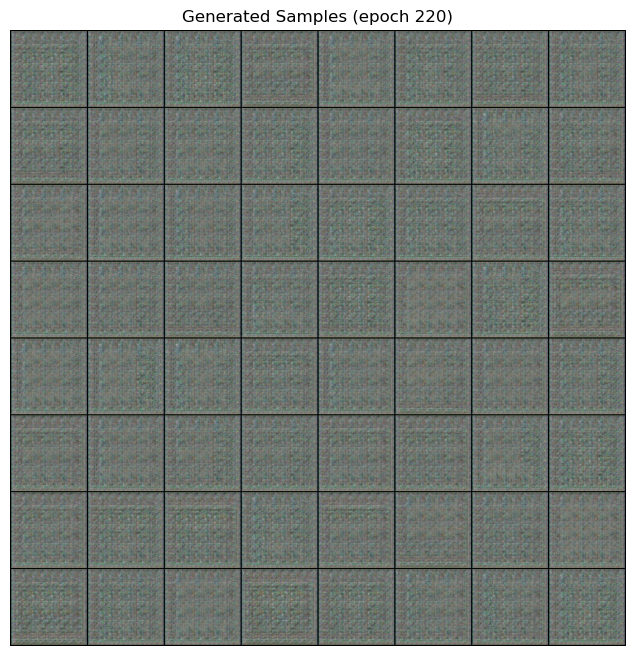

compute FID of a folder with pokemon128 statistics
Found 256 images in the folder outputs/fid_samples/epoch_0220


FID epoch_0220 : 100%|██████████| 8/8 [01:01<00:00,  7.64s/it]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
[Metrics @ epoch 220] FID: 449.94 | MS-SSIM: 0.8560 (lower=more diverse)
==> Epoch 220 done. 100.6s | G 6.476 / D 0.363


In [41]:
def latest_ckpt(ckpt_dir=CKPT_DIR) -> Optional[Path]:
    files = sorted(ckpt_dir.glob("ckpt-*.pt"))
    return files[-1] if files else None

def resume(ckpt_path: Optional[Path]=None) -> int:
    if ckpt_path is None:
        ckpt_path = latest_ckpt()
        if ckpt_path is None: raise FileNotFoundError("No checkpoint found.")
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    netG.load_state_dict(ckpt["netG"]); netD.load_state_dict(ckpt["netD"])
    optG.load_state_dict(ckpt["optG"]); optD.load_state_dict(ckpt["optD"])
    print(f"[Resume] {ckpt_path.name} (epoch {ckpt['epoch']})")
    return int(ckpt["epoch"])

def train_more(additional_epochs=100, from_ckpt: Optional[Path]=None):
    last = resume(from_ckpt)        
    train(start_epoch=last, epochs=additional_epochs)  
    
train_more(additional_epochs=200)

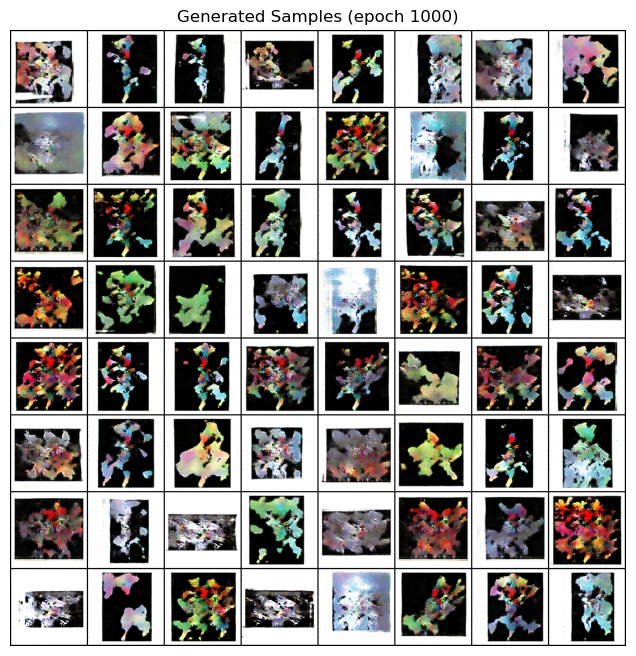

compute FID of a folder with pokemon128 statistics
Found 256 images in the folder outputs/fid_samples/epoch_1000


FID epoch_1000 : 100%|██████████| 8/8 [01:29<00:00, 11.20s/it]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
[Metrics @ epoch 1000] FID: 240.37 | MS-SSIM: 0.2619 (lower=more diverse)
==> Epoch 1000 done. 151.3s | G 5.456 / D 0.345


In [42]:
train_more(additional_epochs=780)